In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
import pmdarima as pm
import concurrent.futures
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import threading

In [2]:
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.")
warnings.filterwarnings("ignore", message="No supported index is available. Prediction results will be given with an integer index beginning at `start`.")
warnings.filterwarnings("ignore", message="No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found. Using zeros as starting parameters.")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.")

In [3]:
data = pd.read_csv("Clean_UoB_Set01_2025-01-02tapes.csv")

In [4]:
data.head()

,Unnamed: 0,Time,Weighted_Price,Total_Size,Order_Number
0,0,10.881,267.0,1.0,1.0
1,1,11.067,269.0,1.0,1.0
2,2,11.222,267.0,2.0,1.0
3,3,12.338,270.0,2.0,1.0
4,4,13.733,267.0,3.0,1.0


In [5]:
data_copy = data[['Time','Weighted_Price']].copy()

In [6]:
data_copy['Time'] = pd.to_datetime(data_copy['Time'], unit='s')

In [7]:
data_copy.set_index('Time',inplace=True)

In [8]:
data_copy

,Weighted_Price
Time,
1970-01-01 00:00:10.881,267.000000
1970-01-01 00:00:11.067,269.000000
1970-01-01 00:00:11.222,267.000000
1970-01-01 00:00:12.338,270.000000
1970-01-01 00:00:13.733,267.000000
...,...
1970-01-01 08:29:54.830,285.333333
1970-01-01 08:29:56.225,286.000000
1970-01-01 08:29:58.085,287.500000


In [29]:
# Arima 5s multithreading version
start_time = datetime.strptime("1970-01-01 00:00:00.000", "%Y-%m-%d %H:%M:%S.%f")
pred = pd.DataFrame([])

def process_data(i):
    current_start = start_time + timedelta(seconds=i*5)
    current_end = current_start + timedelta(seconds=600)
    print(f"{current_start} - {current_end}"+" start")
    print("threads counts:", threading.active_count())
    data_copy_slice = data_copy.loc[current_start:current_end]
    model = ARIMA(data_copy_slice, order=(1, 2, 1))
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=5)
    forecast = pd.DataFrame([forecast.tolist()+[i]])
    print(f"{current_start} - {current_end}"+" end")
    return forecast

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_data, i) for i in range(6000)]

    for future in concurrent.futures.as_completed(futures):
        pred = pd.concat([pred, future.result()])
        
pred.columns = ["0","1","2","3","4","5"]
pred = pred.sort_values(by="5")
pred = pred.iloc[:, pred.columns != '5'].stack()

1970-01-01 00:00:00 - 1970-01-01 00:10:00 start
threads counts: 8
1970-01-01 00:00:05 - 1970-01-01 00:10:05 start
threads counts: 9
1970-01-01 00:00:10 - 1970-01-01 00:10:10 start
threads counts: 10
1970-01-01 00:00:15 - 1970-01-01 00:10:15 start
threads counts: 11
1970-01-01 00:00:20 - 1970-01-01 00:10:20 start
threads counts: 12
1970-01-01 00:00:25 - 1970-01-01 00:10:25 start
threads counts: 13
1970-01-01 00:00:30 - 1970-01-01 00:10:30 start
threads counts: 14
1970-01-01 00:00:35 - 1970-01-01 00:10:35 start
threads counts: 15
1970-01-01 00:00:40 - 1970-01-01 00:10:40 start
threads counts: 16
1970-01-01 00:00:45 - 1970-01-01 00:10:45 start
threads counts: 17
1970-01-01 00:00:50 - 1970-01-01 00:10:50 start
threads counts: 18
1970-01-01 00:00:55 - 1970-01-01 00:10:55 start
threads counts: 19
1970-01-01 00:01:00 - 1970-01-01 00:11:00 start
threads counts: 20
1970-01-01 00:01:05 - 1970-01-01 00:11:05 start
threads counts: 21
1970-01-01 00:01:10 - 1970-01-01 00:11:10 start
threads counts: 

1970-01-01 00:04:30 - 1970-01-01 00:14:30 end
1970-01-01 00:06:55 - 1970-01-01 00:16:55 start
threads counts: 31
1970-01-01 00:05:15 - 1970-01-01 00:15:15 end
1970-01-01 00:07:00 - 1970-01-01 00:17:00 start
threads counts: 31
1970-01-01 00:04:55 - 1970-01-01 00:14:55 end
1970-01-01 00:07:05 - 1970-01-01 00:17:05 start
threads counts: 31
1970-01-01 00:05:25 - 1970-01-01 00:15:25 end
1970-01-01 00:07:10 - 1970-01-01 00:17:10 start
threads counts: 31
1970-01-01 00:05:05 - 1970-01-01 00:15:05 end
1970-01-01 00:07:15 - 1970-01-01 00:17:15 start
threads counts: 31
1970-01-01 00:05:40 - 1970-01-01 00:15:40 end
1970-01-01 00:07:20 - 1970-01-01 00:17:20 start
threads counts: 31
1970-01-01 00:05:30 - 1970-01-01 00:15:30 end
1970-01-01 00:07:25 - 1970-01-01 00:17:25 start
threads counts: 31
1970-01-01 00:05:00 - 1970-01-01 00:15:00 end
1970-01-01 00:07:30 - 1970-01-01 00:17:30 start
threads counts: 31
1970-01-01 00:05:20 - 1970-01-01 00:15:20 end
1970-01-01 00:07:35 - 1970-01-01 00:17:35 start
th

1970-01-01 00:11:05 - 1970-01-01 00:21:05 end
1970-01-01 00:13:10 - 1970-01-01 00:23:10 start
threads counts: 31
1970-01-01 00:11:35 - 1970-01-01 00:21:35 end
1970-01-01 00:13:15 - 1970-01-01 00:23:15 start
threads counts: 31
1970-01-01 00:11:10 - 1970-01-01 00:21:10 end
1970-01-01 00:13:20 - 1970-01-01 00:23:20 start
threads counts: 31
1970-01-01 00:11:40 - 1970-01-01 00:21:40 end
1970-01-01 00:13:25 - 1970-01-01 00:23:25 start
threads counts: 31
1970-01-01 00:11:20 - 1970-01-01 00:21:20 end
1970-01-01 00:13:30 - 1970-01-01 00:23:30 start
threads counts: 31
1970-01-01 00:11:15 - 1970-01-01 00:21:15 end
1970-01-01 00:13:35 - 1970-01-01 00:23:35 start
threads counts: 31
1970-01-01 00:11:50 - 1970-01-01 00:21:50 end
1970-01-01 00:13:40 - 1970-01-01 00:23:40 start
threads counts: 31
1970-01-01 00:11:45 - 1970-01-01 00:21:45 end
1970-01-01 00:13:45 - 1970-01-01 00:23:45 start
threads counts: 31
1970-01-01 00:11:30 - 1970-01-01 00:21:30 end
1970-01-01 00:13:50 - 1970-01-01 00:23:50 start
th

1970-01-01 00:17:20 - 1970-01-01 00:27:20 end
1970-01-01 00:19:25 - 1970-01-01 00:29:25 start
threads counts: 31
1970-01-01 00:18:00 - 1970-01-01 00:28:00 end
1970-01-01 00:19:30 - 1970-01-01 00:29:30 start
threads counts: 31
1970-01-01 00:17:30 - 1970-01-01 00:27:30 end
1970-01-01 00:19:35 - 1970-01-01 00:29:35 start
threads counts: 31
1970-01-01 00:17:45 - 1970-01-01 00:27:45 end
1970-01-01 00:19:40 - 1970-01-01 00:29:40 start
threads counts: 31
1970-01-01 00:17:55 - 1970-01-01 00:27:55 end
1970-01-01 00:19:45 - 1970-01-01 00:29:45 start
threads counts: 31
1970-01-01 00:17:40 - 1970-01-01 00:27:40 end
1970-01-01 00:19:50 - 1970-01-01 00:29:50 start
threads counts: 31
1970-01-01 00:18:10 - 1970-01-01 00:28:10 end
1970-01-01 00:19:55 - 1970-01-01 00:29:55 start
threads counts: 31
1970-01-01 00:18:05 - 1970-01-01 00:28:05 end
1970-01-01 00:20:00 - 1970-01-01 00:30:00 start
threads counts: 31
1970-01-01 00:17:50 - 1970-01-01 00:27:50 end
1970-01-01 00:20:05 - 1970-01-01 00:30:05 start
th

1970-01-01 00:23:50 - 1970-01-01 00:33:50 end
1970-01-01 00:25:45 - 1970-01-01 00:35:45 start
threads counts: 31
1970-01-01 00:23:45 - 1970-01-01 00:33:45 end
1970-01-01 00:25:50 - 1970-01-01 00:35:50 start
threads counts: 31
1970-01-01 00:24:05 - 1970-01-01 00:34:05 end
1970-01-01 00:25:55 - 1970-01-01 00:35:55 start
threads counts: 31
1970-01-01 00:24:40 - 1970-01-01 00:34:40 end1970-01-01 00:24:20 - 1970-01-01 00:34:20 end
1970-01-01 00:26:00 - 1970-01-01 00:36:00 start
threads counts: 31

1970-01-01 00:26:05 - 1970-01-01 00:36:05 start
threads counts: 31
1970-01-01 00:24:00 - 1970-01-01 00:34:00 end
1970-01-01 00:26:10 - 1970-01-01 00:36:10 start
threads counts: 31
1970-01-01 00:24:30 - 1970-01-01 00:34:30 end
1970-01-01 00:26:15 - 1970-01-01 00:36:15 start
threads counts: 31
1970-01-01 00:24:15 - 1970-01-01 00:34:15 end
1970-01-01 00:26:20 - 1970-01-01 00:36:20 start
threads counts: 31
1970-01-01 00:24:25 - 1970-01-01 00:34:25 end
1970-01-01 00:26:25 - 1970-01-01 00:36:25 start
th

1970-01-01 00:29:50 - 1970-01-01 00:39:50 end
1970-01-01 00:31:50 - 1970-01-01 00:41:50 start
threads counts: 31
1970-01-01 00:30:05 - 1970-01-01 00:40:05 end
1970-01-01 00:31:55 - 1970-01-01 00:41:55 start
threads counts: 31
1970-01-01 00:30:25 - 1970-01-01 00:40:25 end
1970-01-01 00:32:00 - 1970-01-01 00:42:00 start
threads counts: 31
1970-01-01 00:29:55 - 1970-01-01 00:39:55 end
1970-01-01 00:32:05 - 1970-01-01 00:42:05 start
threads counts: 31
1970-01-01 00:30:10 - 1970-01-01 00:40:10 end
1970-01-01 00:32:10 - 1970-01-01 00:42:10 start
threads counts: 31
1970-01-01 00:30:30 - 1970-01-01 00:40:30 end
1970-01-01 00:32:15 - 1970-01-01 00:42:15 start
threads counts: 31
1970-01-01 00:30:00 - 1970-01-01 00:40:00 end
1970-01-01 00:32:20 - 1970-01-01 00:42:20 start
threads counts: 31
1970-01-01 00:30:40 - 1970-01-01 00:40:40 end
1970-01-01 00:32:25 - 1970-01-01 00:42:25 start
threads counts: 31
1970-01-01 00:30:50 - 1970-01-01 00:40:50 end
1970-01-01 00:32:30 - 1970-01-01 00:42:30 start
th

1970-01-01 00:35:35 - 1970-01-01 00:45:35 end
1970-01-01 00:37:55 - 1970-01-01 00:47:55 start
threads counts: 31
1970-01-01 00:36:15 - 1970-01-01 00:46:15 end
1970-01-01 00:38:00 - 1970-01-01 00:48:00 start
threads counts: 31
1970-01-01 00:36:20 - 1970-01-01 00:46:20 end
1970-01-01 00:38:05 - 1970-01-01 00:48:05 start
threads counts: 31
1970-01-01 00:36:05 - 1970-01-01 00:46:05 end
1970-01-01 00:38:10 - 1970-01-01 00:48:10 start
threads counts: 31
1970-01-01 00:36:10 - 1970-01-01 00:46:10 end
1970-01-01 00:38:15 - 1970-01-01 00:48:15 start
threads counts: 31
1970-01-01 00:36:25 - 1970-01-01 00:46:25 end
1970-01-01 00:38:20 - 1970-01-01 00:48:20 start
threads counts: 31
1970-01-01 00:36:30 - 1970-01-01 00:46:30 end
1970-01-01 00:38:25 - 1970-01-01 00:48:25 start
threads counts: 31
1970-01-01 00:36:40 - 1970-01-01 00:46:40 end
1970-01-01 00:38:30 - 1970-01-01 00:48:30 start
threads counts: 31
1970-01-01 00:36:45 - 1970-01-01 00:46:45 end
1970-01-01 00:38:35 - 1970-01-01 00:48:35 start
th

1970-01-01 00:42:05 - 1970-01-01 00:52:05 end
1970-01-01 00:44:00 - 1970-01-01 00:54:00 start
threads counts: 31
1970-01-01 00:42:15 - 1970-01-01 00:52:15 end
1970-01-01 00:44:05 - 1970-01-01 00:54:05 start
threads counts: 31
1970-01-01 00:42:35 - 1970-01-01 00:52:35 end
1970-01-01 00:44:10 - 1970-01-01 00:54:10 start
threads counts: 31
1970-01-01 00:42:25 - 1970-01-01 00:52:25 end
1970-01-01 00:44:15 - 1970-01-01 00:54:15 start
threads counts: 31
1970-01-01 00:43:05 - 1970-01-01 00:53:05 end
1970-01-01 00:44:20 - 1970-01-01 00:54:20 start
threads counts: 31
1970-01-01 00:43:00 - 1970-01-01 00:53:00 end
1970-01-01 00:44:25 - 1970-01-01 00:54:25 start
threads counts: 31
1970-01-01 00:42:45 - 1970-01-01 00:52:45 end
1970-01-01 00:44:30 - 1970-01-01 00:54:30 start
threads counts: 31
1970-01-01 00:42:30 - 1970-01-01 00:52:30 end
1970-01-01 00:44:35 - 1970-01-01 00:54:35 start
threads counts: 31
1970-01-01 00:42:10 - 1970-01-01 00:52:10 end
1970-01-01 00:44:40 - 1970-01-01 00:54:40 start
th

1970-01-01 00:48:25 - 1970-01-01 00:58:25 end
1970-01-01 00:50:10 - 1970-01-01 01:00:10 start
threads counts: 31
1970-01-01 00:48:20 - 1970-01-01 00:58:20 end
1970-01-01 00:50:15 - 1970-01-01 01:00:15 start
threads counts: 31
1970-01-01 00:48:35 - 1970-01-01 00:58:35 end
1970-01-01 00:50:20 - 1970-01-01 01:00:20 start
threads counts: 31
1970-01-01 00:48:40 - 1970-01-01 00:58:40 end
1970-01-01 00:50:25 - 1970-01-01 01:00:25 start
threads counts: 31
1970-01-01 00:48:15 - 1970-01-01 00:58:15 end
1970-01-01 00:50:30 - 1970-01-01 01:00:30 start
threads counts: 31
1970-01-01 00:48:55 - 1970-01-01 00:58:55 end
1970-01-01 00:50:35 - 1970-01-01 01:00:35 start
threads counts: 31
1970-01-01 00:48:45 - 1970-01-01 00:58:45 end
1970-01-01 00:50:40 - 1970-01-01 01:00:40 start
threads counts: 31
1970-01-01 00:49:15 - 1970-01-01 00:59:15 end
1970-01-01 00:50:45 - 1970-01-01 01:00:45 start
threads counts: 31
1970-01-01 00:49:20 - 1970-01-01 00:59:20 end
1970-01-01 00:50:50 - 1970-01-01 01:00:50 start
th

1970-01-01 00:54:15 - 1970-01-01 01:04:15 end
1970-01-01 00:56:15 - 1970-01-01 01:06:15 start
threads counts: 31
1970-01-01 00:55:00 - 1970-01-01 01:05:00 end
1970-01-01 00:56:20 - 1970-01-01 01:06:20 start
threads counts: 31
1970-01-01 00:54:30 - 1970-01-01 01:04:30 end
1970-01-01 00:56:25 - 1970-01-01 01:06:25 start
threads counts: 31
1970-01-01 00:54:35 - 1970-01-01 01:04:35 end
1970-01-01 00:56:30 - 1970-01-01 01:06:30 start
threads counts: 31
1970-01-01 00:55:05 - 1970-01-01 01:05:05 end
1970-01-01 00:56:35 - 1970-01-01 01:06:35 start
threads counts: 31
1970-01-01 00:54:50 - 1970-01-01 01:04:50 end
1970-01-01 00:56:40 - 1970-01-01 01:06:40 start
threads counts: 31
1970-01-01 00:54:45 - 1970-01-01 01:04:45 end
1970-01-01 00:56:45 - 1970-01-01 01:06:45 start
threads counts: 31
1970-01-01 00:54:40 - 1970-01-01 01:04:40 end
1970-01-01 00:56:50 - 1970-01-01 01:06:50 start
threads counts: 31
1970-01-01 00:55:10 - 1970-01-01 01:05:10 end1970-01-01 00:54:20 - 1970-01-01 01:04:20 end
1970-

1970-01-01 01:00:30 - 1970-01-01 01:10:30 end
1970-01-01 01:02:25 - 1970-01-01 01:12:25 start
threads counts: 31
1970-01-01 01:00:00 - 1970-01-01 01:10:00 end
1970-01-01 01:02:30 - 1970-01-01 01:12:30 start
threads counts: 31
1970-01-01 01:00:55 - 1970-01-01 01:10:55 end
1970-01-01 01:02:35 - 1970-01-01 01:12:35 start
threads counts: 31
1970-01-01 01:00:50 - 1970-01-01 01:10:50 end
1970-01-01 01:02:40 - 1970-01-01 01:12:40 start
threads counts: 31
1970-01-01 01:01:35 - 1970-01-01 01:11:35 end
1970-01-01 01:02:45 - 1970-01-01 01:12:45 start
threads counts: 31
1970-01-01 01:00:45 - 1970-01-01 01:10:45 end
1970-01-01 01:02:50 - 1970-01-01 01:12:50 start
threads counts: 31
1970-01-01 01:01:00 - 1970-01-01 01:11:00 end
1970-01-01 01:02:55 - 1970-01-01 01:12:55 start
threads counts: 31
1970-01-01 01:01:15 - 1970-01-01 01:11:15 end
1970-01-01 01:03:00 - 1970-01-01 01:13:00 start
threads counts: 31
1970-01-01 01:01:10 - 1970-01-01 01:11:10 end
1970-01-01 01:03:05 - 1970-01-01 01:13:05 start
th

1970-01-01 01:06:10 - 1970-01-01 01:16:10 end
1970-01-01 01:08:40 - 1970-01-01 01:18:40 start
threads counts: 31
1970-01-01 01:06:55 - 1970-01-01 01:16:55 end
1970-01-01 01:08:45 - 1970-01-01 01:18:45 start
threads counts: 31
1970-01-01 01:06:00 - 1970-01-01 01:16:00 end
1970-01-01 01:08:50 - 1970-01-01 01:18:50 start
threads counts: 31
1970-01-01 01:06:45 - 1970-01-01 01:16:45 end
1970-01-01 01:08:55 - 1970-01-01 01:18:55 start
threads counts: 31
1970-01-01 01:07:05 - 1970-01-01 01:17:05 end
1970-01-01 01:09:00 - 1970-01-01 01:19:00 start
threads counts: 31
1970-01-01 01:07:00 - 1970-01-01 01:17:00 end
1970-01-01 01:09:05 - 1970-01-01 01:19:05 start
threads counts: 31
1970-01-01 01:07:15 - 1970-01-01 01:17:15 end
1970-01-01 01:09:10 - 1970-01-01 01:19:10 start
threads counts: 31
1970-01-01 01:07:10 - 1970-01-01 01:17:10 end
1970-01-01 01:09:15 - 1970-01-01 01:19:15 start
threads counts: 31
1970-01-01 01:07:25 - 1970-01-01 01:17:25 end
1970-01-01 01:09:20 - 1970-01-01 01:19:20 start
th

1970-01-01 01:12:35 - 1970-01-01 01:22:35 end
1970-01-01 01:14:45 - 1970-01-01 01:24:45 start
threads counts: 31
1970-01-01 01:12:40 - 1970-01-01 01:22:40 end
1970-01-01 01:14:50 - 1970-01-01 01:24:50 start
threads counts: 31
1970-01-01 01:13:00 - 1970-01-01 01:23:00 end
1970-01-01 01:14:55 - 1970-01-01 01:24:55 start
threads counts: 31
1970-01-01 01:12:45 - 1970-01-01 01:22:45 end
1970-01-01 01:15:00 - 1970-01-01 01:25:00 start
threads counts: 31
1970-01-01 01:13:15 - 1970-01-01 01:23:15 end
1970-01-01 01:15:05 - 1970-01-01 01:25:05 start
threads counts: 31
1970-01-01 01:13:30 - 1970-01-01 01:23:30 end
1970-01-01 01:15:10 - 1970-01-01 01:25:10 start
threads counts: 31
1970-01-01 01:13:25 - 1970-01-01 01:23:25 end
1970-01-01 01:15:15 - 1970-01-01 01:25:15 start
threads counts: 31
1970-01-01 01:14:05 - 1970-01-01 01:24:05 end
1970-01-01 01:15:20 - 1970-01-01 01:25:20 start
threads counts: 31
1970-01-01 01:13:20 - 1970-01-01 01:23:20 end
1970-01-01 01:15:25 - 1970-01-01 01:25:25 start
th

1970-01-01 01:18:30 - 1970-01-01 01:28:30 end
1970-01-01 01:20:55 - 1970-01-01 01:30:55 start
threads counts: 31
1970-01-01 01:19:10 - 1970-01-01 01:29:10 end
1970-01-01 01:21:00 - 1970-01-01 01:31:00 start
threads counts: 31
1970-01-01 01:19:15 - 1970-01-01 01:29:15 end
1970-01-01 01:21:05 - 1970-01-01 01:31:05 start
threads counts: 31
1970-01-01 01:19:05 - 1970-01-01 01:29:05 end
1970-01-01 01:21:10 - 1970-01-01 01:31:10 start
threads counts: 31
1970-01-01 01:19:25 - 1970-01-01 01:29:25 end
1970-01-01 01:21:15 - 1970-01-01 01:31:15 start
threads counts: 31
1970-01-01 01:19:45 - 1970-01-01 01:29:45 end
1970-01-01 01:21:20 - 1970-01-01 01:31:20 start
threads counts: 31
1970-01-01 01:19:40 - 1970-01-01 01:29:40 end
1970-01-01 01:21:25 - 1970-01-01 01:31:25 start
threads counts: 31
1970-01-01 01:19:20 - 1970-01-01 01:29:20 end
1970-01-01 01:21:30 - 1970-01-01 01:31:30 start
threads counts: 31
1970-01-01 01:19:00 - 1970-01-01 01:29:00 end
1970-01-01 01:21:35 - 1970-01-01 01:31:35 start
th

1970-01-01 01:24:50 - 1970-01-01 01:34:50 end
1970-01-01 01:27:00 - 1970-01-01 01:37:00 start
threads counts: 31
1970-01-01 01:25:05 - 1970-01-01 01:35:05 end
1970-01-01 01:27:05 - 1970-01-01 01:37:05 start
threads counts: 31
1970-01-01 01:25:30 - 1970-01-01 01:35:30 end
1970-01-01 01:27:10 - 1970-01-01 01:37:10 start
threads counts: 31
1970-01-01 01:25:10 - 1970-01-01 01:35:10 end
1970-01-01 01:27:15 - 1970-01-01 01:37:15 start
threads counts: 31
1970-01-01 01:25:15 - 1970-01-01 01:35:15 end
1970-01-01 01:27:20 - 1970-01-01 01:37:20 start
threads counts: 31
1970-01-01 01:25:20 - 1970-01-01 01:35:20 end
1970-01-01 01:27:25 - 1970-01-01 01:37:25 start
threads counts: 31
1970-01-01 01:24:20 - 1970-01-01 01:34:20 end
1970-01-01 01:27:30 - 1970-01-01 01:37:30 start
threads counts: 31
1970-01-01 01:25:35 - 1970-01-01 01:35:35 end
1970-01-01 01:27:35 - 1970-01-01 01:37:35 start
threads counts: 31
1970-01-01 01:25:40 - 1970-01-01 01:35:40 end
1970-01-01 01:27:40 - 1970-01-01 01:37:40 start
th

1970-01-01 01:31:05 - 1970-01-01 01:41:05 end
1970-01-01 01:33:05 - 1970-01-01 01:43:05 start
threads counts: 31
1970-01-01 01:30:30 - 1970-01-01 01:40:30 end
1970-01-01 01:33:10 - 1970-01-01 01:43:10 start
threads counts: 31
1970-01-01 01:31:15 - 1970-01-01 01:41:15 end
1970-01-01 01:33:15 - 1970-01-01 01:43:15 start
threads counts: 31
1970-01-01 01:31:35 - 1970-01-01 01:41:35 end
1970-01-01 01:33:20 - 1970-01-01 01:43:20 start
threads counts: 31
1970-01-01 01:31:20 - 1970-01-01 01:41:20 end
1970-01-01 01:33:25 - 1970-01-01 01:43:25 start
threads counts: 31
1970-01-01 01:31:30 - 1970-01-01 01:41:30 end
1970-01-01 01:33:30 - 1970-01-01 01:43:30 start
threads counts: 31
1970-01-01 01:32:00 - 1970-01-01 01:42:00 end
1970-01-01 01:33:35 - 1970-01-01 01:43:35 start
threads counts: 31
1970-01-01 01:31:40 - 1970-01-01 01:41:40 end
1970-01-01 01:33:40 - 1970-01-01 01:43:40 start
threads counts: 31
1970-01-01 01:31:45 - 1970-01-01 01:41:45 end
1970-01-01 01:33:45 - 1970-01-01 01:43:45 start
th

1970-01-01 01:37:25 - 1970-01-01 01:47:25 end
1970-01-01 01:39:15 - 1970-01-01 01:49:15 start
threads counts: 31
1970-01-01 01:37:45 - 1970-01-01 01:47:45 end
1970-01-01 01:39:20 - 1970-01-01 01:49:20 start
threads counts: 31
1970-01-01 01:37:35 - 1970-01-01 01:47:35 end
1970-01-01 01:39:25 - 1970-01-01 01:49:25 start
threads counts: 31
1970-01-01 01:37:20 - 1970-01-01 01:47:20 end
1970-01-01 01:39:30 - 1970-01-01 01:49:30 start
threads counts: 31
1970-01-01 01:37:55 - 1970-01-01 01:47:55 end
1970-01-01 01:39:35 - 1970-01-01 01:49:35 start
threads counts: 31
1970-01-01 01:37:40 - 1970-01-01 01:47:40 end
1970-01-01 01:39:40 - 1970-01-01 01:49:40 start
threads counts: 31
1970-01-01 01:38:00 - 1970-01-01 01:48:00 end
1970-01-01 01:39:45 - 1970-01-01 01:49:45 start
threads counts: 31
1970-01-01 01:37:10 - 1970-01-01 01:47:10 end
1970-01-01 01:39:50 - 1970-01-01 01:49:50 start
threads counts: 31
1970-01-01 01:37:30 - 1970-01-01 01:47:30 end
1970-01-01 01:39:55 - 1970-01-01 01:49:55 start
th

1970-01-01 01:43:30 - 1970-01-01 01:53:30 end
1970-01-01 01:45:25 - 1970-01-01 01:55:25 start
threads counts: 31
1970-01-01 01:43:35 - 1970-01-01 01:53:35 end
1970-01-01 01:45:30 - 1970-01-01 01:55:30 start
threads counts: 31
1970-01-01 01:43:50 - 1970-01-01 01:53:50 end
1970-01-01 01:45:35 - 1970-01-01 01:55:35 start
threads counts: 31
1970-01-01 01:43:05 - 1970-01-01 01:53:05 end
1970-01-01 01:45:40 - 1970-01-01 01:55:40 start
threads counts: 31
1970-01-01 01:43:45 - 1970-01-01 01:53:45 end
1970-01-01 01:45:45 - 1970-01-01 01:55:45 start
threads counts: 31
1970-01-01 01:43:55 - 1970-01-01 01:53:55 end
1970-01-01 01:45:50 - 1970-01-01 01:55:50 start
threads counts: 31
1970-01-01 01:43:40 - 1970-01-01 01:53:40 end
1970-01-01 01:45:55 - 1970-01-01 01:55:55 start
threads counts: 31
1970-01-01 01:44:25 - 1970-01-01 01:54:25 end
1970-01-01 01:46:00 - 1970-01-01 01:56:00 start
threads counts: 31
1970-01-01 01:44:05 - 1970-01-01 01:54:05 end
1970-01-01 01:46:05 - 1970-01-01 01:56:05 start
th

1970-01-01 01:49:45 - 1970-01-01 01:59:45 end
1970-01-01 01:51:30 - 1970-01-01 02:01:30 start
threads counts: 31
1970-01-01 01:49:50 - 1970-01-01 01:59:50 end
1970-01-01 01:51:35 - 1970-01-01 02:01:35 start
threads counts: 31
1970-01-01 01:49:40 - 1970-01-01 01:59:40 end
1970-01-01 01:51:40 - 1970-01-01 02:01:40 start
threads counts: 31
1970-01-01 01:50:05 - 1970-01-01 02:00:05 end
1970-01-01 01:51:45 - 1970-01-01 02:01:45 start
threads counts: 31
1970-01-01 01:49:00 - 1970-01-01 01:59:00 end
1970-01-01 01:51:50 - 1970-01-01 02:01:50 start
threads counts: 31
1970-01-01 01:49:05 - 1970-01-01 01:59:05 end
1970-01-01 01:51:55 - 1970-01-01 02:01:55 start
threads counts: 31
1970-01-01 01:49:55 - 1970-01-01 01:59:55 end
1970-01-01 01:52:00 - 1970-01-01 02:02:00 start
threads counts: 31
1970-01-01 01:50:00 - 1970-01-01 02:00:00 end
1970-01-01 01:52:05 - 1970-01-01 02:02:05 start
threads counts: 31
1970-01-01 01:50:10 - 1970-01-01 02:00:10 end
1970-01-01 01:52:10 - 1970-01-01 02:02:10 start
th

1970-01-01 01:54:30 - 1970-01-01 02:04:30 end
1970-01-01 01:57:45 - 1970-01-01 02:07:45 start
threads counts: 31
1970-01-01 01:56:00 - 1970-01-01 02:06:00 end
1970-01-01 01:57:50 - 1970-01-01 02:07:50 start
threads counts: 31
1970-01-01 01:55:55 - 1970-01-01 02:05:55 end
1970-01-01 01:57:55 - 1970-01-01 02:07:55 start
threads counts: 31
1970-01-01 01:56:25 - 1970-01-01 02:06:25 end
1970-01-01 01:58:00 - 1970-01-01 02:08:00 start
threads counts: 31
1970-01-01 01:55:40 - 1970-01-01 02:05:40 end
1970-01-01 01:58:05 - 1970-01-01 02:08:05 start
threads counts: 31
1970-01-01 01:56:20 - 1970-01-01 02:06:20 end
1970-01-01 01:58:10 - 1970-01-01 02:08:10 start
threads counts: 31
1970-01-01 01:56:30 - 1970-01-01 02:06:30 end1970-01-01 01:56:50 - 1970-01-01 02:06:50 end
1970-01-01 01:58:15 - 1970-01-01 02:08:15 start
threads counts: 31

1970-01-01 01:58:20 - 1970-01-01 02:08:20 start
threads counts: 31
1970-01-01 01:56:55 - 1970-01-01 02:06:55 end
1970-01-01 01:58:25 - 1970-01-01 02:08:25 start
th

1970-01-01 02:02:20 - 1970-01-01 02:12:20 end
1970-01-01 02:04:00 - 1970-01-01 02:14:00 start
threads counts: 31
1970-01-01 02:01:20 - 1970-01-01 02:11:20 end
1970-01-01 02:04:05 - 1970-01-01 02:14:05 start
threads counts: 31
1970-01-01 02:02:30 - 1970-01-01 02:12:30 end
1970-01-01 02:04:10 - 1970-01-01 02:14:10 start
threads counts: 31
1970-01-01 02:01:40 - 1970-01-01 02:11:40 end
1970-01-01 02:04:15 - 1970-01-01 02:14:15 start
threads counts: 31
1970-01-01 02:02:25 - 1970-01-01 02:12:25 end
1970-01-01 02:04:20 - 1970-01-01 02:14:20 start
threads counts: 31
1970-01-01 02:01:55 - 1970-01-01 02:11:55 end
1970-01-01 02:04:25 - 1970-01-01 02:14:25 start
threads counts: 31
1970-01-01 02:02:10 - 1970-01-01 02:12:10 end
1970-01-01 02:04:30 - 1970-01-01 02:14:30 start
threads counts: 31
1970-01-01 02:01:35 - 1970-01-01 02:11:35 end
1970-01-01 02:04:35 - 1970-01-01 02:14:35 start
threads counts: 31
1970-01-01 02:02:50 - 1970-01-01 02:12:50 end
1970-01-01 02:04:40 - 1970-01-01 02:14:40 start
th

1970-01-01 02:08:00 - 1970-01-01 02:18:00 end
1970-01-01 02:10:05 - 1970-01-01 02:20:05 start
threads counts: 31
1970-01-01 02:07:50 - 1970-01-01 02:17:50 end
1970-01-01 02:10:10 - 1970-01-01 02:20:10 start
threads counts: 31
1970-01-01 02:08:30 - 1970-01-01 02:18:30 end
1970-01-01 02:10:15 - 1970-01-01 02:20:15 start
threads counts: 31
1970-01-01 02:08:20 - 1970-01-01 02:18:20 end
1970-01-01 02:10:20 - 1970-01-01 02:20:20 start
threads counts: 31
1970-01-01 02:08:25 - 1970-01-01 02:18:25 end
1970-01-01 02:10:25 - 1970-01-01 02:20:25 start
threads counts: 31
1970-01-01 02:08:45 - 1970-01-01 02:18:45 end
1970-01-01 02:10:30 - 1970-01-01 02:20:30 start
threads counts: 31
1970-01-01 02:08:15 - 1970-01-01 02:18:15 end
1970-01-01 02:10:35 - 1970-01-01 02:20:35 start
threads counts: 31
1970-01-01 02:09:05 - 1970-01-01 02:19:05 end
1970-01-01 02:10:40 - 1970-01-01 02:20:40 start
threads counts: 31
1970-01-01 02:08:50 - 1970-01-01 02:18:50 end
1970-01-01 02:10:45 - 1970-01-01 02:20:45 start
th

1970-01-01 02:13:55 - 1970-01-01 02:23:55 end
1970-01-01 02:16:15 - 1970-01-01 02:26:15 start
threads counts: 31
1970-01-01 02:13:50 - 1970-01-01 02:23:50 end
1970-01-01 02:16:20 - 1970-01-01 02:26:20 start
threads counts: 31
1970-01-01 02:14:30 - 1970-01-01 02:24:30 end
1970-01-01 02:16:25 - 1970-01-01 02:26:25 start
threads counts: 31
1970-01-01 02:14:35 - 1970-01-01 02:24:35 end
1970-01-01 02:16:30 - 1970-01-01 02:26:30 start
threads counts: 31
1970-01-01 02:14:25 - 1970-01-01 02:24:25 end
1970-01-01 02:16:35 - 1970-01-01 02:26:35 start
threads counts: 31
1970-01-01 02:14:50 - 1970-01-01 02:24:50 end
1970-01-01 02:16:40 - 1970-01-01 02:26:40 start
threads counts: 31
1970-01-01 02:15:05 - 1970-01-01 02:25:05 end
1970-01-01 02:16:45 - 1970-01-01 02:26:45 start
threads counts: 31
1970-01-01 02:14:45 - 1970-01-01 02:24:45 end
1970-01-01 02:16:50 - 1970-01-01 02:26:50 start
threads counts: 31
1970-01-01 02:15:00 - 1970-01-01 02:25:00 end
1970-01-01 02:16:55 - 1970-01-01 02:26:55 start
th

1970-01-01 02:20:20 - 1970-01-01 02:30:20 end
1970-01-01 02:22:25 - 1970-01-01 02:32:25 start
threads counts: 31
1970-01-01 02:20:30 - 1970-01-01 02:30:30 end
1970-01-01 02:22:30 - 1970-01-01 02:32:30 start
threads counts: 31
1970-01-01 02:20:35 - 1970-01-01 02:30:35 end
1970-01-01 02:22:35 - 1970-01-01 02:32:35 start
threads counts: 31
1970-01-01 02:20:50 - 1970-01-01 02:30:50 end
1970-01-01 02:22:40 - 1970-01-01 02:32:40 start
threads counts: 31
1970-01-01 02:20:55 - 1970-01-01 02:30:55 end
1970-01-01 02:22:45 - 1970-01-01 02:32:45 start
threads counts: 31
1970-01-01 02:20:40 - 1970-01-01 02:30:40 end
1970-01-01 02:22:50 - 1970-01-01 02:32:50 start
threads counts: 31
1970-01-01 02:20:45 - 1970-01-01 02:30:45 end
1970-01-01 02:22:55 - 1970-01-01 02:32:55 start
threads counts: 31
1970-01-01 02:21:35 - 1970-01-01 02:31:35 end
1970-01-01 02:23:00 - 1970-01-01 02:33:00 start
threads counts: 31
1970-01-01 02:21:25 - 1970-01-01 02:31:25 end
1970-01-01 02:23:05 - 1970-01-01 02:33:05 start
th

1970-01-01 02:27:05 - 1970-01-01 02:37:05 end
1970-01-01 02:28:35 - 1970-01-01 02:38:35 start
threads counts: 31
1970-01-01 02:26:50 - 1970-01-01 02:36:50 end
1970-01-01 02:28:40 - 1970-01-01 02:38:40 start
threads counts: 31
1970-01-01 02:26:45 - 1970-01-01 02:36:45 end
1970-01-01 02:28:45 - 1970-01-01 02:38:45 start
threads counts: 31
1970-01-01 02:27:10 - 1970-01-01 02:37:10 end
1970-01-01 02:28:50 - 1970-01-01 02:38:50 start
threads counts: 31
1970-01-01 02:27:00 - 1970-01-01 02:37:00 end
1970-01-01 02:28:55 - 1970-01-01 02:38:55 start
threads counts: 31
1970-01-01 02:26:35 - 1970-01-01 02:36:35 end
1970-01-01 02:29:00 - 1970-01-01 02:39:00 start
threads counts: 31
1970-01-01 02:27:30 - 1970-01-01 02:37:30 end
1970-01-01 02:29:05 - 1970-01-01 02:39:05 start
threads counts: 31
1970-01-01 02:27:35 - 1970-01-01 02:37:35 end
1970-01-01 02:29:10 - 1970-01-01 02:39:10 start
threads counts: 31
1970-01-01 02:27:20 - 1970-01-01 02:37:20 end
1970-01-01 02:29:15 - 1970-01-01 02:39:15 start
th

1970-01-01 02:32:55 - 1970-01-01 02:42:55 end
1970-01-01 02:34:40 - 1970-01-01 02:44:40 start
threads counts: 31
1970-01-01 02:32:35 - 1970-01-01 02:42:35 end
1970-01-01 02:34:45 - 1970-01-01 02:44:45 start
threads counts: 31
1970-01-01 02:32:50 - 1970-01-01 02:42:50 end
1970-01-01 02:34:50 - 1970-01-01 02:44:50 start
threads counts: 31
1970-01-01 02:33:00 - 1970-01-01 02:43:00 end
1970-01-01 02:34:55 - 1970-01-01 02:44:55 start
threads counts: 31
1970-01-01 02:33:15 - 1970-01-01 02:43:15 end
1970-01-01 02:35:00 - 1970-01-01 02:45:00 start
threads counts: 31
1970-01-01 02:33:10 - 1970-01-01 02:43:10 end
1970-01-01 02:35:05 - 1970-01-01 02:45:05 start
threads counts: 31
1970-01-01 02:32:45 - 1970-01-01 02:42:45 end
1970-01-01 02:35:10 - 1970-01-01 02:45:10 start
threads counts: 31
1970-01-01 02:33:05 - 1970-01-01 02:43:05 end
1970-01-01 02:35:15 - 1970-01-01 02:45:15 start
threads counts: 31
1970-01-01 02:33:20 - 1970-01-01 02:43:20 end
1970-01-01 02:35:20 - 1970-01-01 02:45:20 start
th

1970-01-01 02:39:00 - 1970-01-01 02:49:00 end
1970-01-01 02:40:50 - 1970-01-01 02:50:50 start
threads counts: 31
1970-01-01 02:38:55 - 1970-01-01 02:48:55 end
1970-01-01 02:40:55 - 1970-01-01 02:50:55 start
threads counts: 31
1970-01-01 02:38:20 - 1970-01-01 02:48:20 end
1970-01-01 02:41:00 - 1970-01-01 02:51:00 start
threads counts: 31
1970-01-01 02:39:05 - 1970-01-01 02:49:05 end
1970-01-01 02:41:05 - 1970-01-01 02:51:05 start
threads counts: 31
1970-01-01 02:39:20 - 1970-01-01 02:49:20 end1970-01-01 02:39:50 - 1970-01-01 02:49:50 end
1970-01-01 02:41:10 - 1970-01-01 02:51:10 start
threads counts: 31

1970-01-01 02:41:15 - 1970-01-01 02:51:15 start
threads counts: 31
1970-01-01 02:39:10 - 1970-01-01 02:49:10 end
1970-01-01 02:41:20 - 1970-01-01 02:51:20 start
threads counts: 31
1970-01-01 02:39:40 - 1970-01-01 02:49:40 end
1970-01-01 02:41:25 - 1970-01-01 02:51:25 start
threads counts: 31
1970-01-01 02:39:30 - 1970-01-01 02:49:30 end
1970-01-01 02:41:30 - 1970-01-01 02:51:30 start
th

1970-01-01 02:44:40 - 1970-01-01 02:54:40 end
1970-01-01 02:46:55 - 1970-01-01 02:56:55 start
threads counts: 31
1970-01-01 02:45:10 - 1970-01-01 02:55:10 end
1970-01-01 02:47:00 - 1970-01-01 02:57:00 start
threads counts: 31
1970-01-01 02:45:00 - 1970-01-01 02:55:00 end
1970-01-01 02:47:05 - 1970-01-01 02:57:05 start
threads counts: 31
1970-01-01 02:45:05 - 1970-01-01 02:55:05 end
1970-01-01 02:47:10 - 1970-01-01 02:57:10 start
threads counts: 31
1970-01-01 02:45:15 - 1970-01-01 02:55:15 end
1970-01-01 02:47:15 - 1970-01-01 02:57:15 start
threads counts: 31
1970-01-01 02:45:20 - 1970-01-01 02:55:20 end
1970-01-01 02:47:20 - 1970-01-01 02:57:20 start
threads counts: 31
1970-01-01 02:45:25 - 1970-01-01 02:55:25 end
1970-01-01 02:47:25 - 1970-01-01 02:57:25 start
threads counts: 31
1970-01-01 02:45:30 - 1970-01-01 02:55:30 end
1970-01-01 02:47:30 - 1970-01-01 02:57:30 start
threads counts: 31
1970-01-01 02:45:35 - 1970-01-01 02:55:35 end
1970-01-01 02:47:35 - 1970-01-01 02:57:35 start
th

1970-01-01 02:51:15 - 1970-01-01 03:01:15 end
1970-01-01 02:53:00 - 1970-01-01 03:03:00 start
threads counts: 31
1970-01-01 02:50:45 - 1970-01-01 03:00:45 end
1970-01-01 02:53:05 - 1970-01-01 03:03:05 start
threads counts: 31
1970-01-01 02:51:40 - 1970-01-01 03:01:40 end
1970-01-01 02:53:10 - 1970-01-01 03:03:10 start
threads counts: 31
1970-01-01 02:51:05 - 1970-01-01 03:01:05 end
1970-01-01 02:53:15 - 1970-01-01 03:03:15 start
threads counts: 31
1970-01-01 02:51:10 - 1970-01-01 03:01:10 end
1970-01-01 02:53:20 - 1970-01-01 03:03:20 start
threads counts: 31
1970-01-01 02:51:25 - 1970-01-01 03:01:25 end
1970-01-01 02:53:25 - 1970-01-01 03:03:25 start
threads counts: 31
1970-01-01 02:51:30 - 1970-01-01 03:01:30 end
1970-01-01 02:53:30 - 1970-01-01 03:03:30 start
threads counts: 31
1970-01-01 02:50:25 - 1970-01-01 03:00:25 end
1970-01-01 02:53:35 - 1970-01-01 03:03:35 start
threads counts: 31
1970-01-01 02:51:35 - 1970-01-01 03:01:35 end
1970-01-01 02:53:40 - 1970-01-01 03:03:40 start
th

1970-01-01 02:56:50 - 1970-01-01 03:06:50 end
1970-01-01 02:59:05 - 1970-01-01 03:09:05 start
threads counts: 31
1970-01-01 02:57:15 - 1970-01-01 03:07:15 end
1970-01-01 02:59:10 - 1970-01-01 03:09:10 start
threads counts: 31
1970-01-01 02:57:00 - 1970-01-01 03:07:00 end
1970-01-01 02:59:15 - 1970-01-01 03:09:15 start
threads counts: 31
1970-01-01 02:57:20 - 1970-01-01 03:07:20 end
1970-01-01 02:59:20 - 1970-01-01 03:09:20 start
threads counts: 31
1970-01-01 02:57:30 - 1970-01-01 03:07:30 end
1970-01-01 02:59:25 - 1970-01-01 03:09:25 start
threads counts: 31
1970-01-01 02:57:35 - 1970-01-01 03:07:35 end
1970-01-01 02:59:30 - 1970-01-01 03:09:30 start
threads counts: 31
1970-01-01 02:57:45 - 1970-01-01 03:07:45 end
1970-01-01 02:59:35 - 1970-01-01 03:09:35 start
threads counts: 31
1970-01-01 02:57:25 - 1970-01-01 03:07:25 end
1970-01-01 02:59:40 - 1970-01-01 03:09:40 start
threads counts: 31
1970-01-01 02:58:00 - 1970-01-01 03:08:00 end
1970-01-01 02:59:45 - 1970-01-01 03:09:45 start
th

1970-01-01 03:03:35 - 1970-01-01 03:13:35 end
1970-01-01 03:05:20 - 1970-01-01 03:15:20 start
threads counts: 31
1970-01-01 03:03:40 - 1970-01-01 03:13:40 end
1970-01-01 03:05:25 - 1970-01-01 03:15:25 start
threads counts: 31
1970-01-01 03:03:15 - 1970-01-01 03:13:15 end
1970-01-01 03:05:30 - 1970-01-01 03:15:30 start
threads counts: 31
1970-01-01 03:03:45 - 1970-01-01 03:13:45 end
1970-01-01 03:05:35 - 1970-01-01 03:15:35 start
threads counts: 31
1970-01-01 03:03:30 - 1970-01-01 03:13:30 end
1970-01-01 03:05:40 - 1970-01-01 03:15:40 start
threads counts: 31
1970-01-01 03:03:55 - 1970-01-01 03:13:55 end
1970-01-01 03:05:45 - 1970-01-01 03:15:45 start
threads counts: 31
1970-01-01 03:03:50 - 1970-01-01 03:13:50 end
1970-01-01 03:05:50 - 1970-01-01 03:15:50 start
threads counts: 31
1970-01-01 03:04:00 - 1970-01-01 03:14:00 end
1970-01-01 03:05:55 - 1970-01-01 03:15:55 start
threads counts: 31
1970-01-01 03:04:15 - 1970-01-01 03:14:15 end
1970-01-01 03:06:00 - 1970-01-01 03:16:00 start
th

1970-01-01 03:10:00 - 1970-01-01 03:20:00 end
1970-01-01 03:11:50 - 1970-01-01 03:21:50 start
threads counts: 31
1970-01-01 03:09:50 - 1970-01-01 03:19:50 end
1970-01-01 03:11:55 - 1970-01-01 03:21:55 start
threads counts: 31
1970-01-01 03:10:10 - 1970-01-01 03:20:10 end
1970-01-01 03:12:00 - 1970-01-01 03:22:00 start
threads counts: 31
1970-01-01 03:09:25 - 1970-01-01 03:19:25 end
1970-01-01 03:12:05 - 1970-01-01 03:22:05 start
threads counts: 31
1970-01-01 03:10:15 - 1970-01-01 03:20:15 end
1970-01-01 03:12:10 - 1970-01-01 03:22:10 start
threads counts: 31
1970-01-01 03:10:20 - 1970-01-01 03:20:20 end
1970-01-01 03:12:15 - 1970-01-01 03:22:15 start
threads counts: 31
1970-01-01 03:10:35 - 1970-01-01 03:20:35 end
1970-01-01 03:12:20 - 1970-01-01 03:22:20 start
threads counts: 31
1970-01-01 03:10:40 - 1970-01-01 03:20:40 end
1970-01-01 03:12:25 - 1970-01-01 03:22:25 start
threads counts: 31
1970-01-01 03:09:00 - 1970-01-01 03:19:00 end
1970-01-01 03:12:30 - 1970-01-01 03:22:30 start
th

1970-01-01 03:16:10 - 1970-01-01 03:26:10 end
1970-01-01 03:18:00 - 1970-01-01 03:28:00 start
threads counts: 31
1970-01-01 03:16:00 - 1970-01-01 03:26:00 end
1970-01-01 03:18:05 - 1970-01-01 03:28:05 start
threads counts: 31
1970-01-01 03:16:15 - 1970-01-01 03:26:15 end
1970-01-01 03:18:10 - 1970-01-01 03:28:10 start
threads counts: 31
1970-01-01 03:16:25 - 1970-01-01 03:26:25 end
1970-01-01 03:18:15 - 1970-01-01 03:28:15 start
threads counts: 31
1970-01-01 03:16:20 - 1970-01-01 03:26:20 end
1970-01-01 03:18:20 - 1970-01-01 03:28:20 start
threads counts: 31
1970-01-01 03:16:35 - 1970-01-01 03:26:35 end
1970-01-01 03:18:25 - 1970-01-01 03:28:25 start
threads counts: 31
1970-01-01 03:16:05 - 1970-01-01 03:26:05 end
1970-01-01 03:18:30 - 1970-01-01 03:28:30 start
threads counts: 31
1970-01-01 03:17:00 - 1970-01-01 03:27:00 end
1970-01-01 03:18:35 - 1970-01-01 03:28:35 start
threads counts: 31
1970-01-01 03:16:45 - 1970-01-01 03:26:45 end
1970-01-01 03:18:40 - 1970-01-01 03:28:40 start
th

1970-01-01 03:22:10 - 1970-01-01 03:32:10 end
1970-01-01 03:24:05 - 1970-01-01 03:34:05 start
threads counts: 31
1970-01-01 03:22:15 - 1970-01-01 03:32:15 end
1970-01-01 03:24:10 - 1970-01-01 03:34:10 start
threads counts: 31
1970-01-01 03:22:20 - 1970-01-01 03:32:20 end
1970-01-01 03:24:15 - 1970-01-01 03:34:15 start
threads counts: 31
1970-01-01 03:21:40 - 1970-01-01 03:31:40 end
1970-01-01 03:24:20 - 1970-01-01 03:34:20 start
threads counts: 31
1970-01-01 03:22:25 - 1970-01-01 03:32:25 end
1970-01-01 03:24:25 - 1970-01-01 03:34:25 start
threads counts: 31
1970-01-01 03:22:45 - 1970-01-01 03:32:45 end
1970-01-01 03:24:30 - 1970-01-01 03:34:30 start
threads counts: 31
1970-01-01 03:22:30 - 1970-01-01 03:32:30 end
1970-01-01 03:24:35 - 1970-01-01 03:34:35 start
threads counts: 31
1970-01-01 03:22:40 - 1970-01-01 03:32:40 end
1970-01-01 03:24:40 - 1970-01-01 03:34:40 start
threads counts: 31
1970-01-01 03:22:35 - 1970-01-01 03:32:35 end
1970-01-01 03:24:45 - 1970-01-01 03:34:45 start
th

1970-01-01 03:28:15 - 1970-01-01 03:38:15 end
1970-01-01 03:30:20 - 1970-01-01 03:40:20 start
threads counts: 31
1970-01-01 03:28:35 - 1970-01-01 03:38:35 end
1970-01-01 03:30:25 - 1970-01-01 03:40:25 start
threads counts: 31
1970-01-01 03:28:30 - 1970-01-01 03:38:30 end
1970-01-01 03:30:30 - 1970-01-01 03:40:30 start
threads counts: 31
1970-01-01 03:28:05 - 1970-01-01 03:38:05 end
1970-01-01 03:30:35 - 1970-01-01 03:40:35 start
threads counts: 31
1970-01-01 03:28:50 - 1970-01-01 03:38:50 end
1970-01-01 03:30:40 - 1970-01-01 03:40:40 start
threads counts: 31
1970-01-01 03:28:45 - 1970-01-01 03:38:45 end
1970-01-01 03:30:45 - 1970-01-01 03:40:45 start
threads counts: 31
1970-01-01 03:28:40 - 1970-01-01 03:38:40 end
1970-01-01 03:30:50 - 1970-01-01 03:40:50 start
threads counts: 31
1970-01-01 03:28:55 - 1970-01-01 03:38:55 end
1970-01-01 03:30:55 - 1970-01-01 03:40:55 start
threads counts: 31
1970-01-01 03:29:00 - 1970-01-01 03:39:00 end
1970-01-01 03:31:00 - 1970-01-01 03:41:00 start
th

1970-01-01 03:35:05 - 1970-01-01 03:45:05 end
1970-01-01 03:36:35 - 1970-01-01 03:46:35 start
threads counts: 31
1970-01-01 03:33:50 - 1970-01-01 03:43:50 end
1970-01-01 03:36:40 - 1970-01-01 03:46:40 start
threads counts: 31
1970-01-01 03:35:00 - 1970-01-01 03:45:00 end
1970-01-01 03:36:45 - 1970-01-01 03:46:45 start
threads counts: 31
1970-01-01 03:35:10 - 1970-01-01 03:45:10 end
1970-01-01 03:36:50 - 1970-01-01 03:46:50 start
threads counts: 31
1970-01-01 03:34:45 - 1970-01-01 03:44:45 end
1970-01-01 03:36:55 - 1970-01-01 03:46:55 start
threads counts: 31
1970-01-01 03:35:25 - 1970-01-01 03:45:25 end
1970-01-01 03:37:00 - 1970-01-01 03:47:00 start
threads counts: 31
1970-01-01 03:34:40 - 1970-01-01 03:44:40 end
1970-01-01 03:37:05 - 1970-01-01 03:47:05 start
threads counts: 31
1970-01-01 03:34:50 - 1970-01-01 03:44:50 end
1970-01-01 03:37:10 - 1970-01-01 03:47:10 start
threads counts: 31
1970-01-01 03:34:55 - 1970-01-01 03:44:55 end
1970-01-01 03:37:15 - 1970-01-01 03:47:15 start
th

1970-01-01 03:40:50 - 1970-01-01 03:50:50 end
1970-01-01 03:42:45 - 1970-01-01 03:52:45 start
threads counts: 31
1970-01-01 03:42:25 - 1970-01-01 03:52:25 end
1970-01-01 03:42:50 - 1970-01-01 03:52:50 start
threads counts: 31
1970-01-01 03:41:05 - 1970-01-01 03:51:05 end
1970-01-01 03:42:55 - 1970-01-01 03:52:55 start
threads counts: 31
1970-01-01 03:40:40 - 1970-01-01 03:50:40 end
1970-01-01 03:43:00 - 1970-01-01 03:53:00 start
threads counts: 31
1970-01-01 03:41:15 - 1970-01-01 03:51:15 end
1970-01-01 03:43:05 - 1970-01-01 03:53:05 start
threads counts: 31
1970-01-01 03:41:25 - 1970-01-01 03:51:25 end
1970-01-01 03:43:10 - 1970-01-01 03:53:10 start
threads counts: 31
1970-01-01 03:41:30 - 1970-01-01 03:51:30 end
1970-01-01 03:43:15 - 1970-01-01 03:53:15 start
threads counts: 31
1970-01-01 03:41:40 - 1970-01-01 03:51:40 end
1970-01-01 03:43:20 - 1970-01-01 03:53:20 start
threads counts: 31
1970-01-01 03:41:10 - 1970-01-01 03:51:10 end
1970-01-01 03:43:25 - 1970-01-01 03:53:25 start
th

1970-01-01 03:46:55 - 1970-01-01 03:56:55 end
1970-01-01 03:48:55 - 1970-01-01 03:58:55 start
threads counts: 31
1970-01-01 03:47:05 - 1970-01-01 03:57:05 end
1970-01-01 03:49:00 - 1970-01-01 03:59:00 start
threads counts: 31
1970-01-01 03:47:00 - 1970-01-01 03:57:00 end
1970-01-01 03:49:05 - 1970-01-01 03:59:05 start
threads counts: 31
1970-01-01 03:47:25 - 1970-01-01 03:57:25 end
1970-01-01 03:49:10 - 1970-01-01 03:59:10 start
threads counts: 31
1970-01-01 03:47:30 - 1970-01-01 03:57:30 end
1970-01-01 03:49:15 - 1970-01-01 03:59:15 start
threads counts: 31
1970-01-01 03:47:10 - 1970-01-01 03:57:10 end
1970-01-01 03:49:20 - 1970-01-01 03:59:20 start
threads counts: 31
1970-01-01 03:47:40 - 1970-01-01 03:57:40 end
1970-01-01 03:49:25 - 1970-01-01 03:59:25 start
threads counts: 31
1970-01-01 03:47:50 - 1970-01-01 03:57:50 end
1970-01-01 03:49:30 - 1970-01-01 03:59:30 start
threads counts: 31
1970-01-01 03:47:15 - 1970-01-01 03:57:15 end
1970-01-01 03:49:35 - 1970-01-01 03:59:35 start
th

1970-01-01 03:53:30 - 1970-01-01 04:03:30 end
1970-01-01 03:55:10 - 1970-01-01 04:05:10 start
threads counts: 31
1970-01-01 03:52:40 - 1970-01-01 04:02:40 end
1970-01-01 03:55:15 - 1970-01-01 04:05:15 start
threads counts: 31
1970-01-01 03:53:05 - 1970-01-01 04:03:05 end
1970-01-01 03:55:20 - 1970-01-01 04:05:20 start
threads counts: 31
1970-01-01 03:53:35 - 1970-01-01 04:03:35 end
1970-01-01 03:55:25 - 1970-01-01 04:05:25 start
threads counts: 31
1970-01-01 03:53:20 - 1970-01-01 04:03:20 end
1970-01-01 03:55:30 - 1970-01-01 04:05:30 start
threads counts: 31
1970-01-01 03:53:40 - 1970-01-01 04:03:40 end
1970-01-01 03:55:35 - 1970-01-01 04:05:35 start
threads counts: 31
1970-01-01 03:54:00 - 1970-01-01 04:04:00 end
1970-01-01 03:55:40 - 1970-01-01 04:05:40 start
threads counts: 31
1970-01-01 03:53:45 - 1970-01-01 04:03:45 end
1970-01-01 03:55:45 - 1970-01-01 04:05:45 start
threads counts: 31
1970-01-01 03:53:50 - 1970-01-01 04:03:50 end
1970-01-01 03:55:50 - 1970-01-01 04:05:50 start
th

1970-01-01 03:59:25 - 1970-01-01 04:09:25 end
1970-01-01 04:01:15 - 1970-01-01 04:11:15 start
threads counts: 31
1970-01-01 03:59:20 - 1970-01-01 04:09:20 end
1970-01-01 04:01:20 - 1970-01-01 04:11:20 start
threads counts: 31
1970-01-01 03:59:40 - 1970-01-01 04:09:40 end
1970-01-01 04:01:25 - 1970-01-01 04:11:25 start
threads counts: 31
1970-01-01 03:59:15 - 1970-01-01 04:09:15 end
1970-01-01 04:01:30 - 1970-01-01 04:11:30 start
threads counts: 31
1970-01-01 03:59:35 - 1970-01-01 04:09:35 end
1970-01-01 04:01:35 - 1970-01-01 04:11:35 start
threads counts: 31
1970-01-01 03:59:50 - 1970-01-01 04:09:50 end
1970-01-01 04:01:40 - 1970-01-01 04:11:40 start
threads counts: 31
1970-01-01 03:59:45 - 1970-01-01 04:09:45 end
1970-01-01 04:01:45 - 1970-01-01 04:11:45 start
threads counts: 31
1970-01-01 03:59:55 - 1970-01-01 04:09:55 end
1970-01-01 04:01:50 - 1970-01-01 04:11:50 start
threads counts: 31
1970-01-01 04:00:15 - 1970-01-01 04:10:15 end
1970-01-01 04:01:55 - 1970-01-01 04:11:55 start
th

1970-01-01 04:04:35 - 1970-01-01 04:14:35 end
1970-01-01 04:07:20 - 1970-01-01 04:17:20 start
threads counts: 31
1970-01-01 04:05:20 - 1970-01-01 04:15:20 end
1970-01-01 04:07:25 - 1970-01-01 04:17:25 start
threads counts: 31
1970-01-01 04:05:35 - 1970-01-01 04:15:35 end
1970-01-01 04:07:30 - 1970-01-01 04:17:30 start
threads counts: 31
1970-01-01 04:05:25 - 1970-01-01 04:15:25 end
1970-01-01 04:07:35 - 1970-01-01 04:17:35 start
threads counts: 31
1970-01-01 04:05:50 - 1970-01-01 04:15:50 end
1970-01-01 04:07:40 - 1970-01-01 04:17:40 start
threads counts: 31
1970-01-01 04:05:40 - 1970-01-01 04:15:40 end
1970-01-01 04:07:45 - 1970-01-01 04:17:45 start
threads counts: 31
1970-01-01 04:05:55 - 1970-01-01 04:15:55 end
1970-01-01 04:07:50 - 1970-01-01 04:17:50 start
threads counts: 31
1970-01-01 04:06:05 - 1970-01-01 04:16:05 end
1970-01-01 04:07:55 - 1970-01-01 04:17:55 start
threads counts: 31
1970-01-01 04:05:45 - 1970-01-01 04:15:45 end
1970-01-01 04:08:00 - 1970-01-01 04:18:00 start
th

1970-01-01 04:11:30 - 1970-01-01 04:21:30 end
1970-01-01 04:13:30 - 1970-01-01 04:23:30 start
threads counts: 31
1970-01-01 04:11:40 - 1970-01-01 04:21:40 end
1970-01-01 04:13:35 - 1970-01-01 04:23:35 start
threads counts: 31
1970-01-01 04:11:35 - 1970-01-01 04:21:35 end
1970-01-01 04:13:40 - 1970-01-01 04:23:40 start
threads counts: 31
1970-01-01 04:12:05 - 1970-01-01 04:22:05 end
1970-01-01 04:13:45 - 1970-01-01 04:23:45 start
threads counts: 31
1970-01-01 04:11:45 - 1970-01-01 04:21:45 end
1970-01-01 04:13:50 - 1970-01-01 04:23:50 start
threads counts: 31
1970-01-01 04:12:15 - 1970-01-01 04:22:15 end
1970-01-01 04:13:55 - 1970-01-01 04:23:55 start
threads counts: 31
1970-01-01 04:12:00 - 1970-01-01 04:22:00 end
1970-01-01 04:14:00 - 1970-01-01 04:24:00 start
threads counts: 31
1970-01-01 04:12:10 - 1970-01-01 04:22:10 end
1970-01-01 04:14:05 - 1970-01-01 04:24:05 start
threads counts: 31
1970-01-01 04:11:50 - 1970-01-01 04:21:50 end
1970-01-01 04:14:10 - 1970-01-01 04:24:10 start
th

1970-01-01 04:17:55 - 1970-01-01 04:27:55 end
1970-01-01 04:19:50 - 1970-01-01 04:29:50 start
threads counts: 31
1970-01-01 04:18:00 - 1970-01-01 04:28:00 end
1970-01-01 04:19:55 - 1970-01-01 04:29:55 start
threads counts: 31
1970-01-01 04:17:35 - 1970-01-01 04:27:35 end
1970-01-01 04:20:00 - 1970-01-01 04:30:00 start
threads counts: 31
1970-01-01 04:18:05 - 1970-01-01 04:28:05 end
1970-01-01 04:20:05 - 1970-01-01 04:30:05 start
threads counts: 31
1970-01-01 04:18:20 - 1970-01-01 04:28:20 end
1970-01-01 04:20:10 - 1970-01-01 04:30:10 start
threads counts: 31
1970-01-01 04:18:15 - 1970-01-01 04:28:15 end
1970-01-01 04:20:15 - 1970-01-01 04:30:15 start
threads counts: 31
1970-01-01 04:18:30 - 1970-01-01 04:28:30 end
1970-01-01 04:20:20 - 1970-01-01 04:30:20 start
threads counts: 31
1970-01-01 04:18:25 - 1970-01-01 04:28:25 end
1970-01-01 04:20:25 - 1970-01-01 04:30:25 start
threads counts: 31
1970-01-01 04:18:50 - 1970-01-01 04:28:50 end
1970-01-01 04:20:30 - 1970-01-01 04:30:30 start
th

1970-01-01 04:24:00 - 1970-01-01 04:34:00 end
1970-01-01 04:25:55 - 1970-01-01 04:35:55 start
threads counts: 31
1970-01-01 04:23:50 - 1970-01-01 04:33:50 end
1970-01-01 04:26:00 - 1970-01-01 04:36:00 start
threads counts: 31
1970-01-01 04:24:05 - 1970-01-01 04:34:05 end
1970-01-01 04:26:05 - 1970-01-01 04:36:05 start
threads counts: 31
1970-01-01 04:24:15 - 1970-01-01 04:34:15 end
1970-01-01 04:26:10 - 1970-01-01 04:36:10 start
threads counts: 31
1970-01-01 04:24:10 - 1970-01-01 04:34:10 end
1970-01-01 04:26:15 - 1970-01-01 04:36:15 start
threads counts: 31
1970-01-01 04:24:25 - 1970-01-01 04:34:25 end
1970-01-01 04:26:20 - 1970-01-01 04:36:20 start
threads counts: 31
1970-01-01 04:24:50 - 1970-01-01 04:34:50 end
1970-01-01 04:26:25 - 1970-01-01 04:36:25 start
threads counts: 31
1970-01-01 04:24:35 - 1970-01-01 04:34:35 end
1970-01-01 04:26:30 - 1970-01-01 04:36:30 start
threads counts: 31
1970-01-01 04:24:40 - 1970-01-01 04:34:40 end
1970-01-01 04:26:35 - 1970-01-01 04:36:35 start
th

1970-01-01 04:30:25 - 1970-01-01 04:40:25 end
1970-01-01 04:32:00 - 1970-01-01 04:42:00 start
threads counts: 31
1970-01-01 04:30:20 - 1970-01-01 04:40:20 end
1970-01-01 04:32:05 - 1970-01-01 04:42:05 start
threads counts: 31
1970-01-01 04:30:30 - 1970-01-01 04:40:30 end
1970-01-01 04:32:10 - 1970-01-01 04:42:10 start
threads counts: 31
1970-01-01 04:29:45 - 1970-01-01 04:39:45 end
1970-01-01 04:32:15 - 1970-01-01 04:42:15 start
threads counts: 31
1970-01-01 04:30:05 - 1970-01-01 04:40:05 end
1970-01-01 04:32:20 - 1970-01-01 04:42:20 start
threads counts: 31
1970-01-01 04:30:35 - 1970-01-01 04:40:35 end
1970-01-01 04:32:25 - 1970-01-01 04:42:25 start
threads counts: 31
1970-01-01 04:30:40 - 1970-01-01 04:40:40 end
1970-01-01 04:32:30 - 1970-01-01 04:42:30 start
threads counts: 31
1970-01-01 04:29:55 - 1970-01-01 04:39:55 end
1970-01-01 04:32:35 - 1970-01-01 04:42:35 start
threads counts: 31
1970-01-01 04:30:45 - 1970-01-01 04:40:45 end
1970-01-01 04:32:40 - 1970-01-01 04:42:40 start
th

1970-01-01 04:36:25 - 1970-01-01 04:46:25 end
1970-01-01 04:38:20 - 1970-01-01 04:48:20 start
threads counts: 31
1970-01-01 04:36:50 - 1970-01-01 04:46:50 end
1970-01-01 04:38:25 - 1970-01-01 04:48:25 start
threads counts: 31
1970-01-01 04:36:40 - 1970-01-01 04:46:40 end
1970-01-01 04:38:30 - 1970-01-01 04:48:30 start
threads counts: 31
1970-01-01 04:36:10 - 1970-01-01 04:46:10 end
1970-01-01 04:38:35 - 1970-01-01 04:48:35 start
threads counts: 31
1970-01-01 04:36:35 - 1970-01-01 04:46:35 end
1970-01-01 04:38:40 - 1970-01-01 04:48:40 start
threads counts: 31
1970-01-01 04:36:45 - 1970-01-01 04:46:45 end
1970-01-01 04:38:45 - 1970-01-01 04:48:45 start
threads counts: 31
1970-01-01 04:36:55 - 1970-01-01 04:46:55 end
1970-01-01 04:38:50 - 1970-01-01 04:48:50 start
threads counts: 31
1970-01-01 04:37:10 - 1970-01-01 04:47:10 end
1970-01-01 04:38:55 - 1970-01-01 04:48:55 start
threads counts: 31
1970-01-01 04:37:00 - 1970-01-01 04:47:00 end
1970-01-01 04:39:00 - 1970-01-01 04:49:00 start
th

1970-01-01 04:42:45 - 1970-01-01 04:52:45 end
1970-01-01 04:44:30 - 1970-01-01 04:54:30 start
threads counts: 31
1970-01-01 04:41:45 - 1970-01-01 04:51:45 end
1970-01-01 04:44:35 - 1970-01-01 04:54:35 start
threads counts: 31
1970-01-01 04:43:20 - 1970-01-01 04:53:20 end
1970-01-01 04:44:40 - 1970-01-01 04:54:40 start
threads counts: 31
1970-01-01 04:43:05 - 1970-01-01 04:53:05 end
1970-01-01 04:44:45 - 1970-01-01 04:54:45 start
threads counts: 31
1970-01-01 04:43:15 - 1970-01-01 04:53:15 end
1970-01-01 04:44:50 - 1970-01-01 04:54:50 start
threads counts: 31
1970-01-01 04:42:25 - 1970-01-01 04:52:25 end
1970-01-01 04:44:55 - 1970-01-01 04:54:55 start
threads counts: 31
1970-01-01 04:43:25 - 1970-01-01 04:53:25 end
1970-01-01 04:45:00 - 1970-01-01 04:55:00 start
threads counts: 31
1970-01-01 04:42:35 - 1970-01-01 04:52:35 end
1970-01-01 04:45:05 - 1970-01-01 04:55:05 start
threads counts: 31
1970-01-01 04:42:50 - 1970-01-01 04:52:50 end
1970-01-01 04:45:10 - 1970-01-01 04:55:10 start
th

1970-01-01 04:48:45 - 1970-01-01 04:58:45 end
1970-01-01 04:50:35 - 1970-01-01 05:00:35 start
threads counts: 31
1970-01-01 04:48:50 - 1970-01-01 04:58:50 end
1970-01-01 04:50:40 - 1970-01-01 05:00:40 start
threads counts: 31
1970-01-01 04:48:35 - 1970-01-01 04:58:35 end
1970-01-01 04:50:45 - 1970-01-01 05:00:45 start
threads counts: 31
1970-01-01 04:48:55 - 1970-01-01 04:58:55 end
1970-01-01 04:50:50 - 1970-01-01 05:00:50 start
threads counts: 31
1970-01-01 04:49:25 - 1970-01-01 04:59:25 end
1970-01-01 04:50:55 - 1970-01-01 05:00:55 start
threads counts: 31
1970-01-01 04:49:10 - 1970-01-01 04:59:10 end
1970-01-01 04:51:00 - 1970-01-01 05:01:00 start
threads counts: 31
1970-01-01 04:48:40 - 1970-01-01 04:58:40 end
1970-01-01 04:51:05 - 1970-01-01 05:01:05 start
threads counts: 31
1970-01-01 04:49:00 - 1970-01-01 04:59:00 end
1970-01-01 04:51:10 - 1970-01-01 05:01:10 start
threads counts: 31
1970-01-01 04:49:20 - 1970-01-01 04:59:20 end
1970-01-01 04:51:15 - 1970-01-01 05:01:15 start
th

1970-01-01 04:55:10 - 1970-01-01 05:05:10 end
1970-01-01 04:56:45 - 1970-01-01 05:06:45 start
threads counts: 31
1970-01-01 04:54:45 - 1970-01-01 05:04:45 end
1970-01-01 04:56:50 - 1970-01-01 05:06:50 start
threads counts: 31
1970-01-01 04:54:50 - 1970-01-01 05:04:50 end
1970-01-01 04:56:55 - 1970-01-01 05:06:55 start
threads counts: 31
1970-01-01 04:54:55 - 1970-01-01 05:04:55 end
1970-01-01 04:57:00 - 1970-01-01 05:07:00 start
threads counts: 31
1970-01-01 04:55:05 - 1970-01-01 05:05:05 end
1970-01-01 04:57:05 - 1970-01-01 05:07:05 start
threads counts: 31
1970-01-01 04:55:30 - 1970-01-01 05:05:30 end
1970-01-01 04:57:10 - 1970-01-01 05:07:10 start
threads counts: 31
1970-01-01 04:55:20 - 1970-01-01 05:05:20 end
1970-01-01 04:57:15 - 1970-01-01 05:07:15 start
threads counts: 31
1970-01-01 04:55:40 - 1970-01-01 05:05:40 end
1970-01-01 04:57:20 - 1970-01-01 05:07:20 start
threads counts: 31
1970-01-01 04:55:50 - 1970-01-01 05:05:50 end
1970-01-01 04:57:25 - 1970-01-01 05:07:25 start
th

1970-01-01 05:00:35 - 1970-01-01 05:10:35 end
1970-01-01 05:03:00 - 1970-01-01 05:13:00 start
threads counts: 31
1970-01-01 05:01:00 - 1970-01-01 05:11:00 end
1970-01-01 05:03:05 - 1970-01-01 05:13:05 start
threads counts: 31
1970-01-01 05:01:50 - 1970-01-01 05:11:50 end
1970-01-01 05:03:10 - 1970-01-01 05:13:10 start
threads counts: 31
1970-01-01 05:01:45 - 1970-01-01 05:11:45 end
1970-01-01 05:03:15 - 1970-01-01 05:13:15 start
threads counts: 31
1970-01-01 05:01:30 - 1970-01-01 05:11:30 end
1970-01-01 05:03:20 - 1970-01-01 05:13:20 start
threads counts: 31
1970-01-01 05:02:00 - 1970-01-01 05:12:00 end
1970-01-01 05:03:25 - 1970-01-01 05:13:25 start
threads counts: 31
1970-01-01 05:01:25 - 1970-01-01 05:11:25 end
1970-01-01 05:03:30 - 1970-01-01 05:13:30 start
threads counts: 31
1970-01-01 05:00:50 - 1970-01-01 05:10:50 end
1970-01-01 05:03:35 - 1970-01-01 05:13:35 start
threads counts: 31
1970-01-01 05:01:15 - 1970-01-01 05:11:15 end
1970-01-01 05:03:40 - 1970-01-01 05:13:40 start
th

1970-01-01 05:06:45 - 1970-01-01 05:16:45 end
1970-01-01 05:09:05 - 1970-01-01 05:19:05 start
threads counts: 31
1970-01-01 05:07:00 - 1970-01-01 05:17:00 end
1970-01-01 05:09:10 - 1970-01-01 05:19:10 start
threads counts: 31
1970-01-01 05:07:05 - 1970-01-01 05:17:05 end
1970-01-01 05:09:15 - 1970-01-01 05:19:15 start
threads counts: 31
1970-01-01 05:07:20 - 1970-01-01 05:17:20 end
1970-01-01 05:09:20 - 1970-01-01 05:19:20 start
threads counts: 31
1970-01-01 05:07:25 - 1970-01-01 05:17:25 end
1970-01-01 05:09:25 - 1970-01-01 05:19:25 start
threads counts: 31
1970-01-01 05:07:30 - 1970-01-01 05:17:30 end
1970-01-01 05:09:30 - 1970-01-01 05:19:30 start
threads counts: 31
1970-01-01 05:07:40 - 1970-01-01 05:17:40 end
1970-01-01 05:09:35 - 1970-01-01 05:19:35 start
threads counts: 31
1970-01-01 05:07:50 - 1970-01-01 05:17:50 end
1970-01-01 05:09:40 - 1970-01-01 05:19:40 start
threads counts: 31
1970-01-01 05:07:45 - 1970-01-01 05:17:45 end
1970-01-01 05:09:45 - 1970-01-01 05:19:45 start
th

1970-01-01 05:13:55 - 1970-01-01 05:23:55 end
1970-01-01 05:15:30 - 1970-01-01 05:25:30 start
threads counts: 31
1970-01-01 05:13:45 - 1970-01-01 05:23:45 end
1970-01-01 05:15:35 - 1970-01-01 05:25:35 start
threads counts: 31
1970-01-01 05:13:05 - 1970-01-01 05:23:05 end
1970-01-01 05:15:40 - 1970-01-01 05:25:40 start
threads counts: 31
1970-01-01 05:13:35 - 1970-01-01 05:23:35 end
1970-01-01 05:15:45 - 1970-01-01 05:25:45 start
threads counts: 31
1970-01-01 05:13:50 - 1970-01-01 05:23:50 end
1970-01-01 05:15:50 - 1970-01-01 05:25:50 start
threads counts: 31
1970-01-01 05:14:00 - 1970-01-01 05:24:00 end
1970-01-01 05:15:55 - 1970-01-01 05:25:55 start
threads counts: 31
1970-01-01 05:14:05 - 1970-01-01 05:24:05 end
1970-01-01 05:16:00 - 1970-01-01 05:26:00 start
threads counts: 31
1970-01-01 05:14:25 - 1970-01-01 05:24:25 end
1970-01-01 05:16:05 - 1970-01-01 05:26:05 start
threads counts: 31
1970-01-01 05:14:10 - 1970-01-01 05:24:10 end
1970-01-01 05:16:10 - 1970-01-01 05:26:10 start
th

1970-01-01 05:19:50 - 1970-01-01 05:29:50 end
1970-01-01 05:21:35 - 1970-01-01 05:31:35 start
threads counts: 31
1970-01-01 05:18:55 - 1970-01-01 05:28:55 end
1970-01-01 05:21:40 - 1970-01-01 05:31:40 start
threads counts: 31
1970-01-01 05:20:00 - 1970-01-01 05:30:00 end
1970-01-01 05:21:45 - 1970-01-01 05:31:45 start
threads counts: 31
1970-01-01 05:20:25 - 1970-01-01 05:30:25 end
1970-01-01 05:21:50 - 1970-01-01 05:31:50 start
threads counts: 31
1970-01-01 05:20:15 - 1970-01-01 05:30:15 end
1970-01-01 05:21:55 - 1970-01-01 05:31:55 start
threads counts: 31
1970-01-01 05:19:05 - 1970-01-01 05:29:05 end
1970-01-01 05:22:00 - 1970-01-01 05:32:00 start
threads counts: 31
1970-01-01 05:20:20 - 1970-01-01 05:30:20 end
1970-01-01 05:22:05 - 1970-01-01 05:32:05 start
threads counts: 31
1970-01-01 05:20:05 - 1970-01-01 05:30:05 end
1970-01-01 05:22:10 - 1970-01-01 05:32:10 start
threads counts: 31
1970-01-01 05:19:40 - 1970-01-01 05:29:40 end
1970-01-01 05:22:15 - 1970-01-01 05:32:15 start
th

1970-01-01 05:24:40 - 1970-01-01 05:34:40 end
1970-01-01 05:27:45 - 1970-01-01 05:37:45 start
threads counts: 31
1970-01-01 05:25:30 - 1970-01-01 05:35:30 end
1970-01-01 05:27:50 - 1970-01-01 05:37:50 start
threads counts: 31
1970-01-01 05:26:10 - 1970-01-01 05:36:10 end
1970-01-01 05:27:55 - 1970-01-01 05:37:55 start
threads counts: 31
1970-01-01 05:25:55 - 1970-01-01 05:35:55 end
1970-01-01 05:28:00 - 1970-01-01 05:38:00 start
threads counts: 31
1970-01-01 05:26:25 - 1970-01-01 05:36:25 end
1970-01-01 05:28:05 - 1970-01-01 05:38:05 start
threads counts: 31
1970-01-01 05:26:20 - 1970-01-01 05:36:20 end
1970-01-01 05:28:10 - 1970-01-01 05:38:10 start
threads counts: 31
1970-01-01 05:27:10 - 1970-01-01 05:37:10 end
1970-01-01 05:28:15 - 1970-01-01 05:38:15 start
threads counts: 31
1970-01-01 05:26:35 - 1970-01-01 05:36:35 end
1970-01-01 05:28:20 - 1970-01-01 05:38:20 start
threads counts: 31
1970-01-01 05:26:00 - 1970-01-01 05:36:00 end
1970-01-01 05:28:25 - 1970-01-01 05:38:25 start
th

1970-01-01 05:31:55 - 1970-01-01 05:41:55 end
1970-01-01 05:33:50 - 1970-01-01 05:43:50 start
threads counts: 31
1970-01-01 05:31:50 - 1970-01-01 05:41:50 end
1970-01-01 05:33:55 - 1970-01-01 05:43:55 start
threads counts: 31
1970-01-01 05:31:35 - 1970-01-01 05:41:35 end
1970-01-01 05:34:00 - 1970-01-01 05:44:00 start
threads counts: 31
1970-01-01 05:32:10 - 1970-01-01 05:42:10 end
1970-01-01 05:34:05 - 1970-01-01 05:44:05 start
threads counts: 31
1970-01-01 05:32:25 - 1970-01-01 05:42:25 end
1970-01-01 05:34:10 - 1970-01-01 05:44:10 start
threads counts: 31
1970-01-01 05:32:30 - 1970-01-01 05:42:30 end
1970-01-01 05:34:15 - 1970-01-01 05:44:15 start
threads counts: 31
1970-01-01 05:32:15 - 1970-01-01 05:42:15 end
1970-01-01 05:34:20 - 1970-01-01 05:44:20 start
threads counts: 31
1970-01-01 05:32:05 - 1970-01-01 05:42:05 end
1970-01-01 05:34:25 - 1970-01-01 05:44:25 start
threads counts: 31
1970-01-01 05:32:20 - 1970-01-01 05:42:20 end
1970-01-01 05:34:30 - 1970-01-01 05:44:30 start
th

1970-01-01 05:37:50 - 1970-01-01 05:47:50 end
1970-01-01 05:40:00 - 1970-01-01 05:50:00 start
threads counts: 31
1970-01-01 05:38:00 - 1970-01-01 05:48:00 end
1970-01-01 05:40:05 - 1970-01-01 05:50:05 start
threads counts: 31
1970-01-01 05:38:20 - 1970-01-01 05:48:20 end
1970-01-01 05:40:10 - 1970-01-01 05:50:10 start
threads counts: 31
1970-01-01 05:38:15 - 1970-01-01 05:48:15 end
1970-01-01 05:40:15 - 1970-01-01 05:50:15 start
threads counts: 31
1970-01-01 05:38:10 - 1970-01-01 05:48:10 end
1970-01-01 05:40:20 - 1970-01-01 05:50:20 start
threads counts: 31
1970-01-01 05:38:25 - 1970-01-01 05:48:25 end
1970-01-01 05:40:25 - 1970-01-01 05:50:25 start
threads counts: 31
1970-01-01 05:38:40 - 1970-01-01 05:48:40 end
1970-01-01 05:40:30 - 1970-01-01 05:50:30 start
threads counts: 31
1970-01-01 05:38:30 - 1970-01-01 05:48:30 end
1970-01-01 05:40:35 - 1970-01-01 05:50:35 start
threads counts: 31
1970-01-01 05:38:35 - 1970-01-01 05:48:35 end
1970-01-01 05:40:40 - 1970-01-01 05:50:40 start
th

1970-01-01 05:44:10 - 1970-01-01 05:54:10 end
1970-01-01 05:46:05 - 1970-01-01 05:56:05 start
threads counts: 31
1970-01-01 05:44:20 - 1970-01-01 05:54:20 end
1970-01-01 05:46:10 - 1970-01-01 05:56:10 start
threads counts: 31
1970-01-01 05:44:40 - 1970-01-01 05:54:40 end
1970-01-01 05:46:15 - 1970-01-01 05:56:15 start
threads counts: 31
1970-01-01 05:44:25 - 1970-01-01 05:54:25 end
1970-01-01 05:46:20 - 1970-01-01 05:56:20 start
threads counts: 31
1970-01-01 05:44:00 - 1970-01-01 05:54:00 end
1970-01-01 05:46:25 - 1970-01-01 05:56:25 start
threads counts: 31
1970-01-01 05:44:35 - 1970-01-01 05:54:35 end
1970-01-01 05:46:30 - 1970-01-01 05:56:30 start
threads counts: 31
1970-01-01 05:44:45 - 1970-01-01 05:54:45 end
1970-01-01 05:46:35 - 1970-01-01 05:56:35 start
threads counts: 31
1970-01-01 05:45:20 - 1970-01-01 05:55:20 end
1970-01-01 05:46:40 - 1970-01-01 05:56:40 start
threads counts: 31
1970-01-01 05:45:25 - 1970-01-01 05:55:25 end
1970-01-01 05:46:45 - 1970-01-01 05:56:45 start
th

1970-01-01 05:50:35 - 1970-01-01 06:00:35 end
1970-01-01 05:52:10 - 1970-01-01 06:02:10 start
threads counts: 31
1970-01-01 05:50:40 - 1970-01-01 06:00:40 end
1970-01-01 05:52:15 - 1970-01-01 06:02:15 start
threads counts: 31
1970-01-01 05:50:45 - 1970-01-01 06:00:45 end
1970-01-01 05:52:20 - 1970-01-01 06:02:20 start
threads counts: 31
1970-01-01 05:49:55 - 1970-01-01 05:59:55 end
1970-01-01 05:52:25 - 1970-01-01 06:02:25 start
threads counts: 31
1970-01-01 05:49:45 - 1970-01-01 05:59:45 end
1970-01-01 05:52:30 - 1970-01-01 06:02:30 start
threads counts: 31
1970-01-01 05:50:50 - 1970-01-01 06:00:50 end
1970-01-01 05:52:35 - 1970-01-01 06:02:35 start
threads counts: 31
1970-01-01 05:50:55 - 1970-01-01 06:00:55 end
1970-01-01 05:52:40 - 1970-01-01 06:02:40 start
threads counts: 31
1970-01-01 05:51:10 - 1970-01-01 06:01:10 end
1970-01-01 05:52:45 - 1970-01-01 06:02:45 start
threads counts: 31
1970-01-01 05:51:05 - 1970-01-01 06:01:05 end
1970-01-01 05:52:50 - 1970-01-01 06:02:50 start
th

1970-01-01 05:56:05 - 1970-01-01 06:06:05 end
1970-01-01 05:58:15 - 1970-01-01 06:08:15 start
threads counts: 31
1970-01-01 05:56:25 - 1970-01-01 06:06:25 end
1970-01-01 05:58:20 - 1970-01-01 06:08:20 start
threads counts: 31
1970-01-01 05:57:05 - 1970-01-01 06:07:05 end
1970-01-01 05:58:25 - 1970-01-01 06:08:25 start
threads counts: 31
1970-01-01 05:56:20 - 1970-01-01 06:06:20 end
1970-01-01 05:58:30 - 1970-01-01 06:08:30 start
threads counts: 31
1970-01-01 05:56:50 - 1970-01-01 06:06:50 end
1970-01-01 05:58:35 - 1970-01-01 06:08:35 start
threads counts: 31
1970-01-01 05:57:15 - 1970-01-01 06:07:15 end
1970-01-01 05:58:40 - 1970-01-01 06:08:40 start
threads counts: 31
1970-01-01 05:57:00 - 1970-01-01 06:07:00 end
1970-01-01 05:58:45 - 1970-01-01 06:08:45 start
threads counts: 31
1970-01-01 05:57:10 - 1970-01-01 06:07:10 end
1970-01-01 05:58:50 - 1970-01-01 06:08:50 start
threads counts: 31
1970-01-01 05:57:20 - 1970-01-01 06:07:20 end
1970-01-01 05:58:55 - 1970-01-01 06:08:55 start
th

1970-01-01 06:02:05 - 1970-01-01 06:12:05 end
1970-01-01 06:04:30 - 1970-01-01 06:14:30 start
threads counts: 31
1970-01-01 06:01:30 - 1970-01-01 06:11:30 end
1970-01-01 06:04:35 - 1970-01-01 06:14:35 start
threads counts: 31
1970-01-01 06:02:30 - 1970-01-01 06:12:30 end
1970-01-01 06:04:40 - 1970-01-01 06:14:40 start
threads counts: 31
1970-01-01 06:02:45 - 1970-01-01 06:12:45 end
1970-01-01 06:04:45 - 1970-01-01 06:14:45 start
threads counts: 31
1970-01-01 06:03:00 - 1970-01-01 06:13:00 end
1970-01-01 06:04:50 - 1970-01-01 06:14:50 start
threads counts: 31
1970-01-01 06:03:20 - 1970-01-01 06:13:20 end
1970-01-01 06:04:55 - 1970-01-01 06:14:55 start
threads counts: 31
1970-01-01 06:02:50 - 1970-01-01 06:12:50 end
1970-01-01 06:05:00 - 1970-01-01 06:15:00 start
threads counts: 31
1970-01-01 06:02:55 - 1970-01-01 06:12:55 end
1970-01-01 06:05:05 - 1970-01-01 06:15:05 start
threads counts: 31
1970-01-01 06:03:05 - 1970-01-01 06:13:05 end
1970-01-01 06:05:10 - 1970-01-01 06:15:10 start
th

1970-01-01 06:08:45 - 1970-01-01 06:18:45 end
1970-01-01 06:10:35 - 1970-01-01 06:20:35 start
threads counts: 31
1970-01-01 06:08:50 - 1970-01-01 06:18:50 end
1970-01-01 06:10:40 - 1970-01-01 06:20:40 start
threads counts: 31
1970-01-01 06:08:55 - 1970-01-01 06:18:55 end
1970-01-01 06:10:45 - 1970-01-01 06:20:45 start
threads counts: 31
1970-01-01 06:09:00 - 1970-01-01 06:19:00 end
1970-01-01 06:10:50 - 1970-01-01 06:20:50 start
threads counts: 31
1970-01-01 06:09:15 - 1970-01-01 06:19:15 end
1970-01-01 06:10:55 - 1970-01-01 06:20:55 start
threads counts: 31
1970-01-01 06:08:40 - 1970-01-01 06:18:40 end
1970-01-01 06:11:00 - 1970-01-01 06:21:00 start
threads counts: 31
1970-01-01 06:07:45 - 1970-01-01 06:17:45 end
1970-01-01 06:11:05 - 1970-01-01 06:21:05 start
threads counts: 31
1970-01-01 06:09:05 - 1970-01-01 06:19:05 end
1970-01-01 06:11:10 - 1970-01-01 06:21:10 start
threads counts: 31
1970-01-01 06:09:40 - 1970-01-01 06:19:40 end
1970-01-01 06:11:15 - 1970-01-01 06:21:15 start
th

1970-01-01 06:14:45 - 1970-01-01 06:24:45 end
1970-01-01 06:16:50 - 1970-01-01 06:26:50 start
threads counts: 31
1970-01-01 06:15:10 - 1970-01-01 06:25:10 end
1970-01-01 06:16:55 - 1970-01-01 06:26:55 start
threads counts: 31
1970-01-01 06:14:50 - 1970-01-01 06:24:50 end
1970-01-01 06:17:00 - 1970-01-01 06:27:00 start
threads counts: 31
1970-01-01 06:15:25 - 1970-01-01 06:25:25 end
1970-01-01 06:17:05 - 1970-01-01 06:27:05 start
threads counts: 31
1970-01-01 06:14:55 - 1970-01-01 06:24:55 end
1970-01-01 06:17:10 - 1970-01-01 06:27:10 start
threads counts: 31
1970-01-01 06:15:00 - 1970-01-01 06:25:00 end
1970-01-01 06:17:15 - 1970-01-01 06:27:15 start
threads counts: 31
1970-01-01 06:15:20 - 1970-01-01 06:25:20 end1970-01-01 06:15:05 - 1970-01-01 06:25:05 end
1970-01-01 06:17:20 - 1970-01-01 06:27:20 start
threads counts: 31

1970-01-01 06:17:25 - 1970-01-01 06:27:25 start
threads counts: 31
1970-01-01 06:15:35 - 1970-01-01 06:25:35 end
1970-01-01 06:17:30 - 1970-01-01 06:27:30 start
th

1970-01-01 06:20:55 - 1970-01-01 06:30:55 end
1970-01-01 06:23:00 - 1970-01-01 06:33:00 start
threads counts: 31
1970-01-01 06:20:35 - 1970-01-01 06:30:35 end
1970-01-01 06:23:05 - 1970-01-01 06:33:05 start
threads counts: 31
1970-01-01 06:21:00 - 1970-01-01 06:31:00 end
1970-01-01 06:23:10 - 1970-01-01 06:33:10 start
threads counts: 31
1970-01-01 06:21:45 - 1970-01-01 06:31:45 end
1970-01-01 06:23:15 - 1970-01-01 06:33:15 start
threads counts: 31
1970-01-01 06:21:30 - 1970-01-01 06:31:30 end
1970-01-01 06:23:20 - 1970-01-01 06:33:20 start
threads counts: 31
1970-01-01 06:21:55 - 1970-01-01 06:31:55 end
1970-01-01 06:23:25 - 1970-01-01 06:33:25 start
threads counts: 31
1970-01-01 06:21:10 - 1970-01-01 06:31:10 end
1970-01-01 06:23:30 - 1970-01-01 06:33:30 start
threads counts: 31
1970-01-01 06:21:35 - 1970-01-01 06:31:35 end
1970-01-01 06:23:35 - 1970-01-01 06:33:35 start
threads counts: 31
1970-01-01 06:21:50 - 1970-01-01 06:31:50 end
1970-01-01 06:23:40 - 1970-01-01 06:33:40 start
th

1970-01-01 06:27:15 - 1970-01-01 06:37:15 end
1970-01-01 06:29:15 - 1970-01-01 06:39:15 start
threads counts: 31
1970-01-01 06:27:25 - 1970-01-01 06:37:25 end
1970-01-01 06:29:20 - 1970-01-01 06:39:20 start
threads counts: 31
1970-01-01 06:27:30 - 1970-01-01 06:37:30 end
1970-01-01 06:29:25 - 1970-01-01 06:39:25 start
threads counts: 31
1970-01-01 06:27:20 - 1970-01-01 06:37:20 end
1970-01-01 06:29:30 - 1970-01-01 06:39:30 start
threads counts: 31
1970-01-01 06:27:35 - 1970-01-01 06:37:35 end
1970-01-01 06:29:35 - 1970-01-01 06:39:35 start
threads counts: 31
1970-01-01 06:27:55 - 1970-01-01 06:37:55 end
1970-01-01 06:29:40 - 1970-01-01 06:39:40 start
threads counts: 31
1970-01-01 06:28:05 - 1970-01-01 06:38:05 end
1970-01-01 06:29:45 - 1970-01-01 06:39:45 start
threads counts: 31
1970-01-01 06:27:40 - 1970-01-01 06:37:40 end
1970-01-01 06:29:50 - 1970-01-01 06:39:50 start
threads counts: 31
1970-01-01 06:28:10 - 1970-01-01 06:38:10 end
1970-01-01 06:29:55 - 1970-01-01 06:39:55 start
th

1970-01-01 06:33:30 - 1970-01-01 06:43:30 end
1970-01-01 06:35:25 - 1970-01-01 06:45:25 start
threads counts: 31
1970-01-01 06:33:50 - 1970-01-01 06:43:50 end
1970-01-01 06:35:30 - 1970-01-01 06:45:30 start
threads counts: 31
1970-01-01 06:33:25 - 1970-01-01 06:43:25 end
1970-01-01 06:35:35 - 1970-01-01 06:45:35 start
threads counts: 31
1970-01-01 06:33:45 - 1970-01-01 06:43:45 end
1970-01-01 06:35:40 - 1970-01-01 06:45:40 start
threads counts: 31
1970-01-01 06:34:45 - 1970-01-01 06:44:45 end
1970-01-01 06:35:45 - 1970-01-01 06:45:45 start
threads counts: 31
1970-01-01 06:34:20 - 1970-01-01 06:44:20 end
1970-01-01 06:35:50 - 1970-01-01 06:45:50 start
threads counts: 31
1970-01-01 06:33:20 - 1970-01-01 06:43:20 end
1970-01-01 06:35:55 - 1970-01-01 06:45:55 start
threads counts: 31
1970-01-01 06:34:30 - 1970-01-01 06:44:30 end
1970-01-01 06:36:00 - 1970-01-01 06:46:00 start
threads counts: 31
1970-01-01 06:33:40 - 1970-01-01 06:43:40 end
1970-01-01 06:36:05 - 1970-01-01 06:46:05 start
th

1970-01-01 06:39:30 - 1970-01-01 06:49:30 end
1970-01-01 06:41:30 - 1970-01-01 06:51:30 start
threads counts: 31
1970-01-01 06:39:25 - 1970-01-01 06:49:25 end
1970-01-01 06:41:35 - 1970-01-01 06:51:35 start
threads counts: 31
1970-01-01 06:39:55 - 1970-01-01 06:49:55 end
1970-01-01 06:41:40 - 1970-01-01 06:51:40 start
threads counts: 31
1970-01-01 06:39:45 - 1970-01-01 06:49:45 end
1970-01-01 06:41:45 - 1970-01-01 06:51:45 start
threads counts: 31
1970-01-01 06:39:40 - 1970-01-01 06:49:40 end
1970-01-01 06:41:50 - 1970-01-01 06:51:50 start
threads counts: 31
1970-01-01 06:40:20 - 1970-01-01 06:50:20 end
1970-01-01 06:41:55 - 1970-01-01 06:51:55 start
threads counts: 31
1970-01-01 06:39:50 - 1970-01-01 06:49:50 end
1970-01-01 06:42:00 - 1970-01-01 06:52:00 start
threads counts: 31
1970-01-01 06:40:00 - 1970-01-01 06:50:00 end
1970-01-01 06:42:05 - 1970-01-01 06:52:05 start
threads counts: 31
1970-01-01 06:40:35 - 1970-01-01 06:50:35 end
1970-01-01 06:42:10 - 1970-01-01 06:52:10 start
th

1970-01-01 06:45:40 - 1970-01-01 06:55:40 end
1970-01-01 06:47:35 - 1970-01-01 06:57:35 start
threads counts: 31
1970-01-01 06:45:45 - 1970-01-01 06:55:45 end
1970-01-01 06:47:40 - 1970-01-01 06:57:40 start
threads counts: 31
1970-01-01 06:45:55 - 1970-01-01 06:55:55 end
1970-01-01 06:47:45 - 1970-01-01 06:57:45 start
threads counts: 31
1970-01-01 06:45:35 - 1970-01-01 06:55:35 end
1970-01-01 06:47:50 - 1970-01-01 06:57:50 start
threads counts: 31
1970-01-01 06:46:05 - 1970-01-01 06:56:05 end
1970-01-01 06:47:55 - 1970-01-01 06:57:55 start
threads counts: 31
1970-01-01 06:46:00 - 1970-01-01 06:56:00 end
1970-01-01 06:48:00 - 1970-01-01 06:58:00 start
threads counts: 31
1970-01-01 06:45:50 - 1970-01-01 06:55:50 end
1970-01-01 06:48:05 - 1970-01-01 06:58:05 start
threads counts: 31
1970-01-01 06:46:15 - 1970-01-01 06:56:15 end
1970-01-01 06:48:10 - 1970-01-01 06:58:10 start
threads counts: 31
1970-01-01 06:46:55 - 1970-01-01 06:56:55 end
1970-01-01 06:48:15 - 1970-01-01 06:58:15 start
th

1970-01-01 06:52:10 - 1970-01-01 07:02:10 end
1970-01-01 06:54:00 - 1970-01-01 07:04:00 start
threads counts: 31
1970-01-01 06:51:45 - 1970-01-01 07:01:45 end
1970-01-01 06:54:05 - 1970-01-01 07:04:05 start
threads counts: 31
1970-01-01 06:52:05 - 1970-01-01 07:02:05 end
1970-01-01 06:54:10 - 1970-01-01 07:04:10 start
threads counts: 31
1970-01-01 06:52:25 - 1970-01-01 07:02:25 end
1970-01-01 06:54:15 - 1970-01-01 07:04:15 start
threads counts: 31
1970-01-01 06:52:20 - 1970-01-01 07:02:20 end
1970-01-01 06:54:20 - 1970-01-01 07:04:20 start
threads counts: 31
1970-01-01 06:52:30 - 1970-01-01 07:02:30 end
1970-01-01 06:54:25 - 1970-01-01 07:04:25 start
threads counts: 31
1970-01-01 06:52:35 - 1970-01-01 07:02:35 end
1970-01-01 06:54:30 - 1970-01-01 07:04:30 start
threads counts: 31
1970-01-01 06:52:45 - 1970-01-01 07:02:45 end
1970-01-01 06:54:35 - 1970-01-01 07:04:35 start
threads counts: 31
1970-01-01 06:52:50 - 1970-01-01 07:02:50 end
1970-01-01 06:54:40 - 1970-01-01 07:04:40 start
th

1970-01-01 06:58:10 - 1970-01-01 07:08:10 end
1970-01-01 07:00:05 - 1970-01-01 07:10:05 start
threads counts: 31
1970-01-01 06:58:20 - 1970-01-01 07:08:20 end
1970-01-01 07:00:10 - 1970-01-01 07:10:10 start
threads counts: 31
1970-01-01 06:57:30 - 1970-01-01 07:07:30 end
1970-01-01 07:00:15 - 1970-01-01 07:10:15 start
threads counts: 31
1970-01-01 06:58:30 - 1970-01-01 07:08:30 end
1970-01-01 07:00:20 - 1970-01-01 07:10:20 start
threads counts: 31
1970-01-01 06:56:55 - 1970-01-01 07:06:55 end
1970-01-01 07:00:25 - 1970-01-01 07:10:25 start
threads counts: 31
1970-01-01 06:58:25 - 1970-01-01 07:08:25 end
1970-01-01 07:00:30 - 1970-01-01 07:10:30 start
threads counts: 31
1970-01-01 06:58:35 - 1970-01-01 07:08:35 end
1970-01-01 07:00:35 - 1970-01-01 07:10:35 start
threads counts: 31
1970-01-01 06:58:45 - 1970-01-01 07:08:45 end
1970-01-01 07:00:40 - 1970-01-01 07:10:40 start
threads counts: 31
1970-01-01 06:58:50 - 1970-01-01 07:08:50 end
1970-01-01 07:00:45 - 1970-01-01 07:10:45 start
th

1970-01-01 07:04:30 - 1970-01-01 07:14:30 end
1970-01-01 07:06:25 - 1970-01-01 07:16:25 start
threads counts: 31
1970-01-01 07:04:50 - 1970-01-01 07:14:50 end
1970-01-01 07:06:30 - 1970-01-01 07:16:30 start
threads counts: 31
1970-01-01 07:04:45 - 1970-01-01 07:14:45 end
1970-01-01 07:06:35 - 1970-01-01 07:16:35 start
threads counts: 31
1970-01-01 07:04:40 - 1970-01-01 07:14:40 end
1970-01-01 07:06:40 - 1970-01-01 07:16:40 start
threads counts: 31
1970-01-01 07:04:55 - 1970-01-01 07:14:55 end
1970-01-01 07:06:45 - 1970-01-01 07:16:45 start
threads counts: 31
1970-01-01 07:03:45 - 1970-01-01 07:13:45 end
1970-01-01 07:06:50 - 1970-01-01 07:16:50 start
threads counts: 31
1970-01-01 07:05:25 - 1970-01-01 07:15:25 end
1970-01-01 07:06:55 - 1970-01-01 07:16:55 start
threads counts: 31
1970-01-01 07:05:05 - 1970-01-01 07:15:05 end
1970-01-01 07:07:00 - 1970-01-01 07:17:00 start
threads counts: 31
1970-01-01 07:05:00 - 1970-01-01 07:15:00 end
1970-01-01 07:07:05 - 1970-01-01 07:17:05 start
th

1970-01-01 07:10:00 - 1970-01-01 07:20:00 end
1970-01-01 07:12:45 - 1970-01-01 07:22:45 start
threads counts: 31
1970-01-01 07:09:50 - 1970-01-01 07:19:50 end
1970-01-01 07:12:50 - 1970-01-01 07:22:50 start
threads counts: 31
1970-01-01 07:11:10 - 1970-01-01 07:21:10 end
1970-01-01 07:12:55 - 1970-01-01 07:22:55 start
threads counts: 31
1970-01-01 07:10:10 - 1970-01-01 07:20:10 end
1970-01-01 07:13:00 - 1970-01-01 07:23:00 start
threads counts: 31
1970-01-01 07:11:05 - 1970-01-01 07:21:05 end
1970-01-01 07:13:05 - 1970-01-01 07:23:05 start
threads counts: 31
1970-01-01 07:11:15 - 1970-01-01 07:21:15 end
1970-01-01 07:13:10 - 1970-01-01 07:23:10 start
threads counts: 31
1970-01-01 07:11:00 - 1970-01-01 07:21:00 end
1970-01-01 07:13:15 - 1970-01-01 07:23:15 start
threads counts: 31
1970-01-01 07:11:20 - 1970-01-01 07:21:20 end
1970-01-01 07:13:20 - 1970-01-01 07:23:20 start
threads counts: 31
1970-01-01 07:11:30 - 1970-01-01 07:21:30 end
1970-01-01 07:13:25 - 1970-01-01 07:23:25 start
th

1970-01-01 07:17:00 - 1970-01-01 07:27:00 end
1970-01-01 07:18:50 - 1970-01-01 07:28:50 start
threads counts: 31
1970-01-01 07:17:10 - 1970-01-01 07:27:10 end
1970-01-01 07:18:55 - 1970-01-01 07:28:55 start
threads counts: 31
1970-01-01 07:15:55 - 1970-01-01 07:25:55 end
1970-01-01 07:19:00 - 1970-01-01 07:29:00 start
threads counts: 31
1970-01-01 07:16:15 - 1970-01-01 07:26:15 end
1970-01-01 07:19:05 - 1970-01-01 07:29:05 start
threads counts: 31
1970-01-01 07:17:25 - 1970-01-01 07:27:25 end
1970-01-01 07:19:10 - 1970-01-01 07:29:10 start
threads counts: 31
1970-01-01 07:17:20 - 1970-01-01 07:27:20 end
1970-01-01 07:19:15 - 1970-01-01 07:29:15 start
threads counts: 31
1970-01-01 07:17:35 - 1970-01-01 07:27:35 end
1970-01-01 07:19:20 - 1970-01-01 07:29:20 start
threads counts: 31
1970-01-01 07:17:05 - 1970-01-01 07:27:05 end
1970-01-01 07:19:25 - 1970-01-01 07:29:25 start
threads counts: 31
1970-01-01 07:17:40 - 1970-01-01 07:27:40 end
1970-01-01 07:19:30 - 1970-01-01 07:29:30 start
th

1970-01-01 07:22:35 - 1970-01-01 07:32:35 end
1970-01-01 07:25:05 - 1970-01-01 07:35:05 start
threads counts: 31
1970-01-01 07:23:20 - 1970-01-01 07:33:20 end
1970-01-01 07:25:10 - 1970-01-01 07:35:10 start
threads counts: 31
1970-01-01 07:23:15 - 1970-01-01 07:33:15 end
1970-01-01 07:25:15 - 1970-01-01 07:35:15 start
threads counts: 31
1970-01-01 07:23:45 - 1970-01-01 07:33:45 end
1970-01-01 07:25:20 - 1970-01-01 07:35:20 start
threads counts: 31
1970-01-01 07:23:50 - 1970-01-01 07:33:50 end
1970-01-01 07:25:25 - 1970-01-01 07:35:25 start
threads counts: 31
1970-01-01 07:23:35 - 1970-01-01 07:33:35 end
1970-01-01 07:25:30 - 1970-01-01 07:35:30 start
threads counts: 31
1970-01-01 07:22:55 - 1970-01-01 07:32:55 end
1970-01-01 07:25:35 - 1970-01-01 07:35:35 start
threads counts: 31
1970-01-01 07:23:00 - 1970-01-01 07:33:00 end
1970-01-01 07:25:40 - 1970-01-01 07:35:40 start
threads counts: 31
1970-01-01 07:23:40 - 1970-01-01 07:33:40 end
1970-01-01 07:25:45 - 1970-01-01 07:35:45 start
th

1970-01-01 07:29:20 - 1970-01-01 07:39:20 end
1970-01-01 07:31:10 - 1970-01-01 07:41:10 start
threads counts: 31
1970-01-01 07:29:05 - 1970-01-01 07:39:05 end
1970-01-01 07:31:15 - 1970-01-01 07:41:15 start
threads counts: 31
1970-01-01 07:29:55 - 1970-01-01 07:39:55 end
1970-01-01 07:31:20 - 1970-01-01 07:41:20 start
threads counts: 31
1970-01-01 07:29:25 - 1970-01-01 07:39:25 end
1970-01-01 07:31:25 - 1970-01-01 07:41:25 start
threads counts: 31
1970-01-01 07:29:10 - 1970-01-01 07:39:10 end
1970-01-01 07:31:30 - 1970-01-01 07:41:30 start
threads counts: 31
1970-01-01 07:29:40 - 1970-01-01 07:39:40 end
1970-01-01 07:31:35 - 1970-01-01 07:41:35 start
threads counts: 31
1970-01-01 07:28:45 - 1970-01-01 07:38:45 end
1970-01-01 07:31:40 - 1970-01-01 07:41:40 start
threads counts: 31
1970-01-01 07:29:50 - 1970-01-01 07:39:50 end
1970-01-01 07:31:45 - 1970-01-01 07:41:45 start
threads counts: 31
1970-01-01 07:29:45 - 1970-01-01 07:39:45 end
1970-01-01 07:31:50 - 1970-01-01 07:41:50 start
th

1970-01-01 07:35:30 - 1970-01-01 07:45:30 end
1970-01-01 07:37:20 - 1970-01-01 07:47:20 start
threads counts: 31
1970-01-01 07:35:20 - 1970-01-01 07:45:20 end
1970-01-01 07:37:25 - 1970-01-01 07:47:25 start
threads counts: 31
1970-01-01 07:35:40 - 1970-01-01 07:45:40 end
1970-01-01 07:37:30 - 1970-01-01 07:47:30 start
threads counts: 31
1970-01-01 07:35:50 - 1970-01-01 07:45:50 end
1970-01-01 07:37:35 - 1970-01-01 07:47:35 start
threads counts: 31
1970-01-01 07:35:55 - 1970-01-01 07:45:55 end
1970-01-01 07:37:40 - 1970-01-01 07:47:40 start
threads counts: 31
1970-01-01 07:35:45 - 1970-01-01 07:45:45 end
1970-01-01 07:37:45 - 1970-01-01 07:47:45 start
threads counts: 31
1970-01-01 07:36:15 - 1970-01-01 07:46:15 end
1970-01-01 07:37:50 - 1970-01-01 07:47:50 start
threads counts: 31
1970-01-01 07:35:00 - 1970-01-01 07:45:00 end
1970-01-01 07:37:55 - 1970-01-01 07:47:55 start
threads counts: 31
1970-01-01 07:36:10 - 1970-01-01 07:46:10 end
1970-01-01 07:38:00 - 1970-01-01 07:48:00 start
th

1970-01-01 07:41:45 - 1970-01-01 07:51:45 end
1970-01-01 07:43:25 - 1970-01-01 07:53:25 start
threads counts: 31
1970-01-01 07:41:20 - 1970-01-01 07:51:20 end
1970-01-01 07:43:30 - 1970-01-01 07:53:30 start
threads counts: 31
1970-01-01 07:41:40 - 1970-01-01 07:51:40 end
1970-01-01 07:43:35 - 1970-01-01 07:53:35 start
threads counts: 31
1970-01-01 07:42:35 - 1970-01-01 07:52:35 end
1970-01-01 07:43:40 - 1970-01-01 07:53:40 start
threads counts: 31
1970-01-01 07:41:50 - 1970-01-01 07:51:50 end
1970-01-01 07:43:45 - 1970-01-01 07:53:45 start
threads counts: 31
1970-01-01 07:41:05 - 1970-01-01 07:51:05 end
1970-01-01 07:43:50 - 1970-01-01 07:53:50 start
threads counts: 31
1970-01-01 07:42:00 - 1970-01-01 07:52:00 end
1970-01-01 07:43:55 - 1970-01-01 07:53:55 start
threads counts: 31
1970-01-01 07:42:05 - 1970-01-01 07:52:05 end
1970-01-01 07:44:00 - 1970-01-01 07:54:00 start
threads counts: 31
1970-01-01 07:42:30 - 1970-01-01 07:52:30 end
1970-01-01 07:44:05 - 1970-01-01 07:54:05 start
th

1970-01-01 07:48:00 - 1970-01-01 07:58:00 end
1970-01-01 07:49:30 - 1970-01-01 07:59:30 start
threads counts: 31
1970-01-01 07:47:55 - 1970-01-01 07:57:55 end
1970-01-01 07:49:35 - 1970-01-01 07:59:35 start
threads counts: 31
1970-01-01 07:47:05 - 1970-01-01 07:57:05 end
1970-01-01 07:49:40 - 1970-01-01 07:59:40 start
threads counts: 31
1970-01-01 07:47:45 - 1970-01-01 07:57:45 end
1970-01-01 07:49:45 - 1970-01-01 07:59:45 start
threads counts: 31
1970-01-01 07:47:40 - 1970-01-01 07:57:40 end
1970-01-01 07:49:50 - 1970-01-01 07:59:50 start
threads counts: 31
1970-01-01 07:47:50 - 1970-01-01 07:57:50 end
1970-01-01 07:49:55 - 1970-01-01 07:59:55 start
threads counts: 31
1970-01-01 07:47:35 - 1970-01-01 07:57:35 end
1970-01-01 07:50:00 - 1970-01-01 08:00:00 start
threads counts: 31
1970-01-01 07:48:05 - 1970-01-01 07:58:05 end
1970-01-01 07:50:05 - 1970-01-01 08:00:05 start
threads counts: 31
1970-01-01 07:48:10 - 1970-01-01 07:58:10 end
1970-01-01 07:50:10 - 1970-01-01 08:00:10 start
th

1970-01-01 07:53:50 - 1970-01-01 08:03:50 end
1970-01-01 07:55:45 - 1970-01-01 08:05:45 start
threads counts: 31
1970-01-01 07:53:25 - 1970-01-01 08:03:25 end
1970-01-01 07:55:50 - 1970-01-01 08:05:50 start
threads counts: 31
1970-01-01 07:53:45 - 1970-01-01 08:03:45 end
1970-01-01 07:55:55 - 1970-01-01 08:05:55 start
threads counts: 31
1970-01-01 07:54:00 - 1970-01-01 08:04:00 end
1970-01-01 07:56:00 - 1970-01-01 08:06:00 start
threads counts: 31
1970-01-01 07:54:05 - 1970-01-01 08:04:05 end
1970-01-01 07:56:05 - 1970-01-01 08:06:05 start
threads counts: 31
1970-01-01 07:54:15 - 1970-01-01 08:04:15 end
1970-01-01 07:56:10 - 1970-01-01 08:06:10 start
threads counts: 31
1970-01-01 07:54:10 - 1970-01-01 08:04:10 end
1970-01-01 07:56:15 - 1970-01-01 08:06:15 start
threads counts: 31
1970-01-01 07:54:25 - 1970-01-01 08:04:25 end
1970-01-01 07:56:20 - 1970-01-01 08:06:20 start
threads counts: 31
1970-01-01 07:54:20 - 1970-01-01 08:04:20 end
1970-01-01 07:56:25 - 1970-01-01 08:06:25 start
th

1970-01-01 08:00:20 - 1970-01-01 08:10:20 end
1970-01-01 08:01:50 - 1970-01-01 08:11:50 start
threads counts: 31
1970-01-01 08:00:05 - 1970-01-01 08:10:05 end
1970-01-01 08:01:55 - 1970-01-01 08:11:55 start
threads counts: 31
1970-01-01 08:00:10 - 1970-01-01 08:10:10 end
1970-01-01 08:02:00 - 1970-01-01 08:12:00 start
threads counts: 31
1970-01-01 07:59:35 - 1970-01-01 08:09:35 end
1970-01-01 08:02:05 - 1970-01-01 08:12:05 start
threads counts: 31
1970-01-01 08:00:00 - 1970-01-01 08:10:00 end
1970-01-01 08:02:10 - 1970-01-01 08:12:10 start
threads counts: 31
1970-01-01 08:00:30 - 1970-01-01 08:10:30 end
1970-01-01 08:02:15 - 1970-01-01 08:12:15 start
threads counts: 31
1970-01-01 08:00:25 - 1970-01-01 08:10:25 end
1970-01-01 08:02:20 - 1970-01-01 08:12:20 start
threads counts: 31
1970-01-01 08:00:15 - 1970-01-01 08:10:15 end
1970-01-01 08:02:25 - 1970-01-01 08:12:25 start
threads counts: 31
1970-01-01 07:59:40 - 1970-01-01 08:09:40 end
1970-01-01 08:02:30 - 1970-01-01 08:12:30 start
th

1970-01-01 08:06:10 - 1970-01-01 08:16:10 end
1970-01-01 08:08:00 - 1970-01-01 08:18:00 start
threads counts: 31
1970-01-01 08:06:05 - 1970-01-01 08:16:05 end
1970-01-01 08:08:05 - 1970-01-01 08:18:05 start
threads counts: 31
1970-01-01 08:05:55 - 1970-01-01 08:15:55 end
1970-01-01 08:08:10 - 1970-01-01 08:18:10 start
threads counts: 31
1970-01-01 08:06:00 - 1970-01-01 08:16:00 end
1970-01-01 08:08:15 - 1970-01-01 08:18:15 start
threads counts: 31
1970-01-01 08:06:25 - 1970-01-01 08:16:25 end
1970-01-01 08:08:20 - 1970-01-01 08:18:20 start
threads counts: 31
1970-01-01 08:06:30 - 1970-01-01 08:16:30 end
1970-01-01 08:08:25 - 1970-01-01 08:18:25 start
threads counts: 31
1970-01-01 08:06:15 - 1970-01-01 08:16:15 end
1970-01-01 08:08:30 - 1970-01-01 08:18:30 start
threads counts: 31
1970-01-01 08:06:55 - 1970-01-01 08:16:55 end
1970-01-01 08:08:35 - 1970-01-01 08:18:35 start
threads counts: 31
1970-01-01 08:06:45 - 1970-01-01 08:16:45 end
1970-01-01 08:08:40 - 1970-01-01 08:18:40 start
th

1970-01-01 08:12:35 - 1970-01-01 08:22:35 end
1970-01-01 08:14:10 - 1970-01-01 08:24:10 start
threads counts: 31
1970-01-01 08:12:25 - 1970-01-01 08:22:25 end
1970-01-01 08:14:15 - 1970-01-01 08:24:15 start
threads counts: 31
1970-01-01 08:11:55 - 1970-01-01 08:21:55 end
1970-01-01 08:14:20 - 1970-01-01 08:24:20 start
threads counts: 31
1970-01-01 08:12:30 - 1970-01-01 08:22:30 end
1970-01-01 08:14:25 - 1970-01-01 08:24:25 start
threads counts: 31
1970-01-01 08:12:55 - 1970-01-01 08:22:55 end
1970-01-01 08:14:30 - 1970-01-01 08:24:30 start
threads counts: 31
1970-01-01 08:11:15 - 1970-01-01 08:21:15 end
1970-01-01 08:14:35 - 1970-01-01 08:24:35 start
threads counts: 31
1970-01-01 08:12:45 - 1970-01-01 08:22:45 end
1970-01-01 08:14:40 - 1970-01-01 08:24:40 start
threads counts: 31
1970-01-01 08:12:20 - 1970-01-01 08:22:20 end
1970-01-01 08:14:45 - 1970-01-01 08:24:45 start
threads counts: 31
1970-01-01 08:12:50 - 1970-01-01 08:22:50 end
1970-01-01 08:14:50 - 1970-01-01 08:24:50 start
th

1970-01-01 08:18:20 - 1970-01-01 08:28:20 end
1970-01-01 08:18:50 - 1970-01-01 08:28:50 end
1970-01-01 08:18:10 - 1970-01-01 08:28:10 end
1970-01-01 08:18:55 - 1970-01-01 08:28:55 end
1970-01-01 08:19:10 - 1970-01-01 08:29:10 end
1970-01-01 08:19:40 - 1970-01-01 08:29:40 end
1970-01-01 08:19:05 - 1970-01-01 08:29:05 end
1970-01-01 08:19:20 - 1970-01-01 08:29:20 end
1970-01-01 08:19:15 - 1970-01-01 08:29:15 end
1970-01-01 08:19:30 - 1970-01-01 08:29:30 end
1970-01-01 08:19:00 - 1970-01-01 08:29:00 end
1970-01-01 08:19:50 - 1970-01-01 08:29:50 end
1970-01-01 08:19:55 - 1970-01-01 08:29:55 end
1970-01-01 08:19:45 - 1970-01-01 08:29:45 end
1970-01-01 08:19:35 - 1970-01-01 08:29:35 end
1970-01-01 08:19:25 - 1970-01-01 08:29:25 end


In [ ]:
# Arima 10s multithreading version
start_time = datetime.strptime("1970-01-01 00:00:00.000", "%Y-%m-%d %H:%M:%S.%f")
pred = pd.DataFrame([])

def process_data(i):
    current_start = start_time + timedelta(seconds=i*10)
    current_end = current_start + timedelta(seconds=600)
    data_copy_slice = data_copy.loc[current_start:current_end]
    model = ARIMA(data_copy_slice, order=(1, 1, 1))
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=10)
    print(f"{current_start} - {current_end}"+" start")
    forecast = pd.DataFrame([forecast.tolist()+[i]])
    return forecast

with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
    futures = [executor.submit(process_data, i) for i in range(3000)]

    for future in concurrent.futures.as_completed(futures):
        pred = pd.concat([pred, future.result()])
        
pred.columns = ["0","1","2","3","4","5","6","7","8","9","10"]
pred = pred.sort_values(by="10")
pred = pred.iloc[:, pred.columns != '10'].stack()

In [ ]:
# Arima fast version
start_time = datetime.strptime("1970-01-01 00:00:00.000", "%Y-%m-%d %H:%M:%S.%f")
pred = pd.Series([])
for i in range(3000):  
    current_start = start_time + timedelta(seconds=i*10)
    current_end = current_start + timedelta(seconds=600)
    data_copy_slice = data_copy.loc[current_start:current_end]
    model = ARIMA(data_copy_slice,order = (1,2,1))
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=10)
    pred = pd.concat([pred,  forecast])
    print(f"{current_start} - {current_end}")

In [ ]:
# Arima slow version
start_time = datetime.strptime("1970-01-01 00:00:00.000", "%Y-%m-%d %H:%M:%S.%f")
pred = pd.Series([])
for i in range(500):  
    current_start = start_time + timedelta(minutes=i)
    current_end = current_start + timedelta(minutes=10)
    data_copy_slice = data_copy.loc["1970-01-01 00:00:00.000":current_end]
    model = ARIMA(data_copy_slice,order = (1,1,1))
    fitted_model = model.fit()
    forecast = fitted_model.forecast(steps=60)
    pred = pd.concat([pred,  forecast])
    print(f"{current_start} - {current_end}")

In [30]:
new_index = pd.date_range(start='1970-01-01 00:10:01', end='1970-01-01 08:30:00', freq='S')
len(new_index),len(pred)

(30000, 30000)

In [31]:
pred.index = new_index

In [32]:
data_copy_slice = data_copy.loc['1970-01-01 00:00:00.000':'1970-01-01 08:30:00']

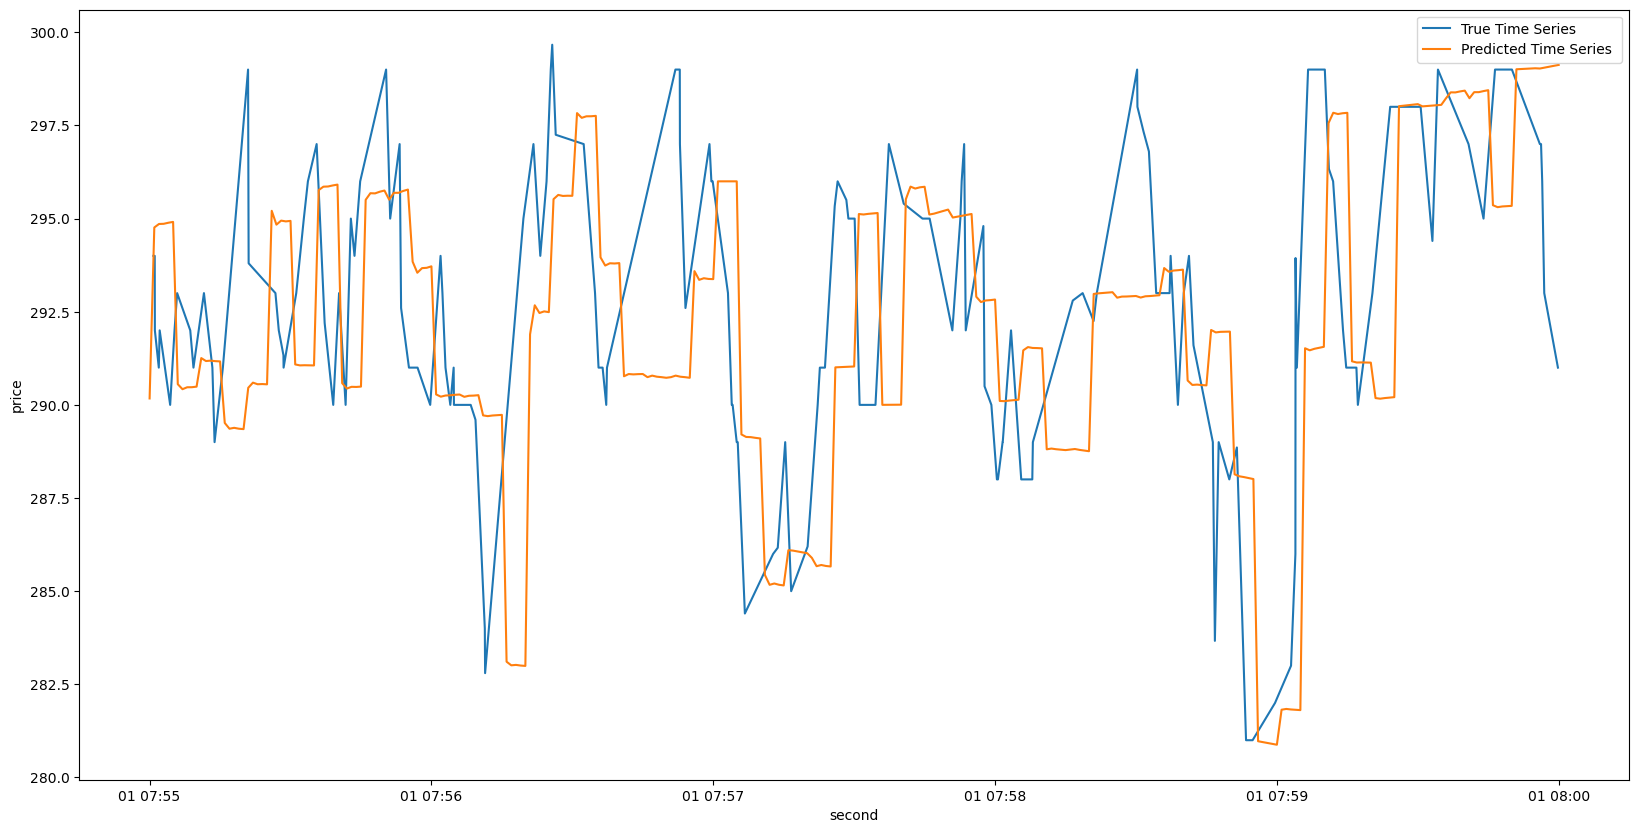

In [39]:
plt.figure(figsize=(20, 10))
plt.plot(data_copy_slice.loc['1970-01-01 07:55:00.000':'1970-01-01 08:00:00'], label='True Time Series')
plt.plot(pred.loc['1970-01-01 07:55:00.000':'1970-01-01 08:00:00'],label = 'Predicted Time Series ')
plt.xlabel('second')
plt.ylabel('price')
plt.legend()
plt.show()

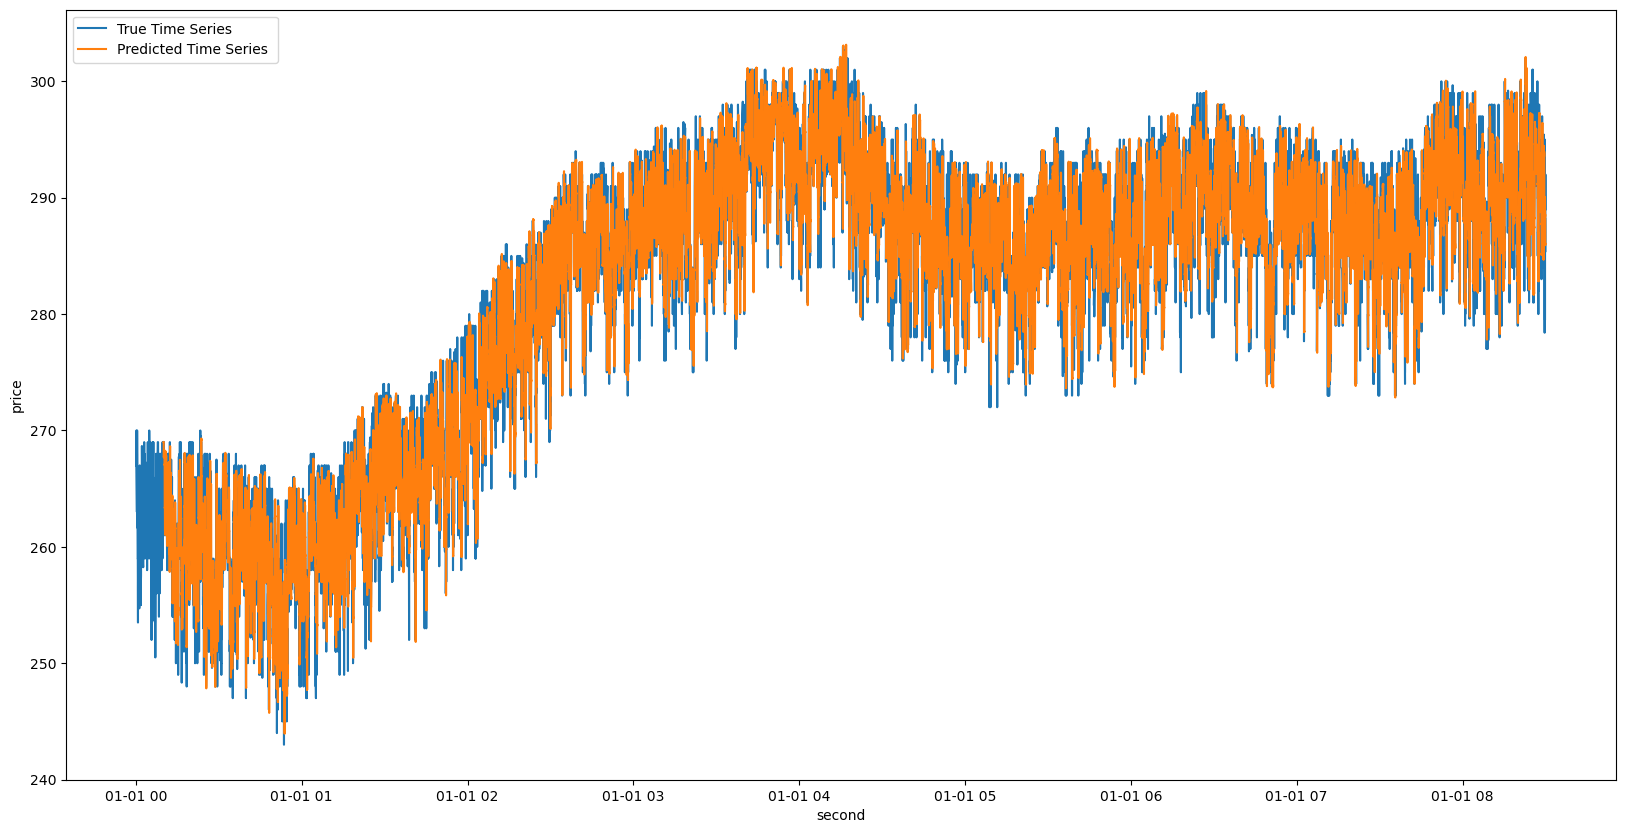

In [33]:
plt.figure(figsize=(20, 10))
plt.plot(data_copy_slice.loc['1970-01-01 00:00:00.000':'1970-01-01 08:30:00'], label='True Time Series')
plt.plot(pred.loc['1970-01-01 00:00:00.000':'1970-01-01 08:30:00'],label = 'Predicted Time Series ')
plt.xlabel('second')
plt.ylabel('price')
plt.legend()
plt.show()

In [34]:
start_time = datetime.strptime("1970-01-01 00:10:00.000", "%Y-%m-%d %H:%M:%S.%f")
mean_true = []
mean_pred = []
for i in range(500):  
    current_start = start_time + timedelta(minutes=i)
    current_end = current_start + timedelta(minutes=1)
    mean_true.append(np.mean(data_copy_slice.loc[current_start:current_end],axis=0))
    mean_pred.append(np.mean(pred.loc[current_start:current_end],axis=0))
    print(f"{current_start} - {current_end}")

1970-01-01 00:10:00 - 1970-01-01 00:11:00
1970-01-01 00:11:00 - 1970-01-01 00:12:00
1970-01-01 00:12:00 - 1970-01-01 00:13:00
1970-01-01 00:13:00 - 1970-01-01 00:14:00
1970-01-01 00:14:00 - 1970-01-01 00:15:00
1970-01-01 00:15:00 - 1970-01-01 00:16:00
1970-01-01 00:16:00 - 1970-01-01 00:17:00
1970-01-01 00:17:00 - 1970-01-01 00:18:00
1970-01-01 00:18:00 - 1970-01-01 00:19:00
1970-01-01 00:19:00 - 1970-01-01 00:20:00
1970-01-01 00:20:00 - 1970-01-01 00:21:00
1970-01-01 00:21:00 - 1970-01-01 00:22:00
1970-01-01 00:22:00 - 1970-01-01 00:23:00
1970-01-01 00:23:00 - 1970-01-01 00:24:00
1970-01-01 00:24:00 - 1970-01-01 00:25:00
1970-01-01 00:25:00 - 1970-01-01 00:26:00
1970-01-01 00:26:00 - 1970-01-01 00:27:00
1970-01-01 00:27:00 - 1970-01-01 00:28:00
1970-01-01 00:28:00 - 1970-01-01 00:29:00
1970-01-01 00:29:00 - 1970-01-01 00:30:00
1970-01-01 00:30:00 - 1970-01-01 00:31:00
1970-01-01 00:31:00 - 1970-01-01 00:32:00
1970-01-01 00:32:00 - 1970-01-01 00:33:00
1970-01-01 00:33:00 - 1970-01-01 0

1970-01-01 05:23:00 - 1970-01-01 05:24:00
1970-01-01 05:24:00 - 1970-01-01 05:25:00
1970-01-01 05:25:00 - 1970-01-01 05:26:00
1970-01-01 05:26:00 - 1970-01-01 05:27:00
1970-01-01 05:27:00 - 1970-01-01 05:28:00
1970-01-01 05:28:00 - 1970-01-01 05:29:00
1970-01-01 05:29:00 - 1970-01-01 05:30:00
1970-01-01 05:30:00 - 1970-01-01 05:31:00
1970-01-01 05:31:00 - 1970-01-01 05:32:00
1970-01-01 05:32:00 - 1970-01-01 05:33:00
1970-01-01 05:33:00 - 1970-01-01 05:34:00
1970-01-01 05:34:00 - 1970-01-01 05:35:00
1970-01-01 05:35:00 - 1970-01-01 05:36:00
1970-01-01 05:36:00 - 1970-01-01 05:37:00
1970-01-01 05:37:00 - 1970-01-01 05:38:00
1970-01-01 05:38:00 - 1970-01-01 05:39:00
1970-01-01 05:39:00 - 1970-01-01 05:40:00
1970-01-01 05:40:00 - 1970-01-01 05:41:00
1970-01-01 05:41:00 - 1970-01-01 05:42:00
1970-01-01 05:42:00 - 1970-01-01 05:43:00
1970-01-01 05:43:00 - 1970-01-01 05:44:00
1970-01-01 05:44:00 - 1970-01-01 05:45:00
1970-01-01 05:45:00 - 1970-01-01 05:46:00
1970-01-01 05:46:00 - 1970-01-01 0

In [35]:
mean_squared_error(mean_true,mean_pred)

0.6240691614817722

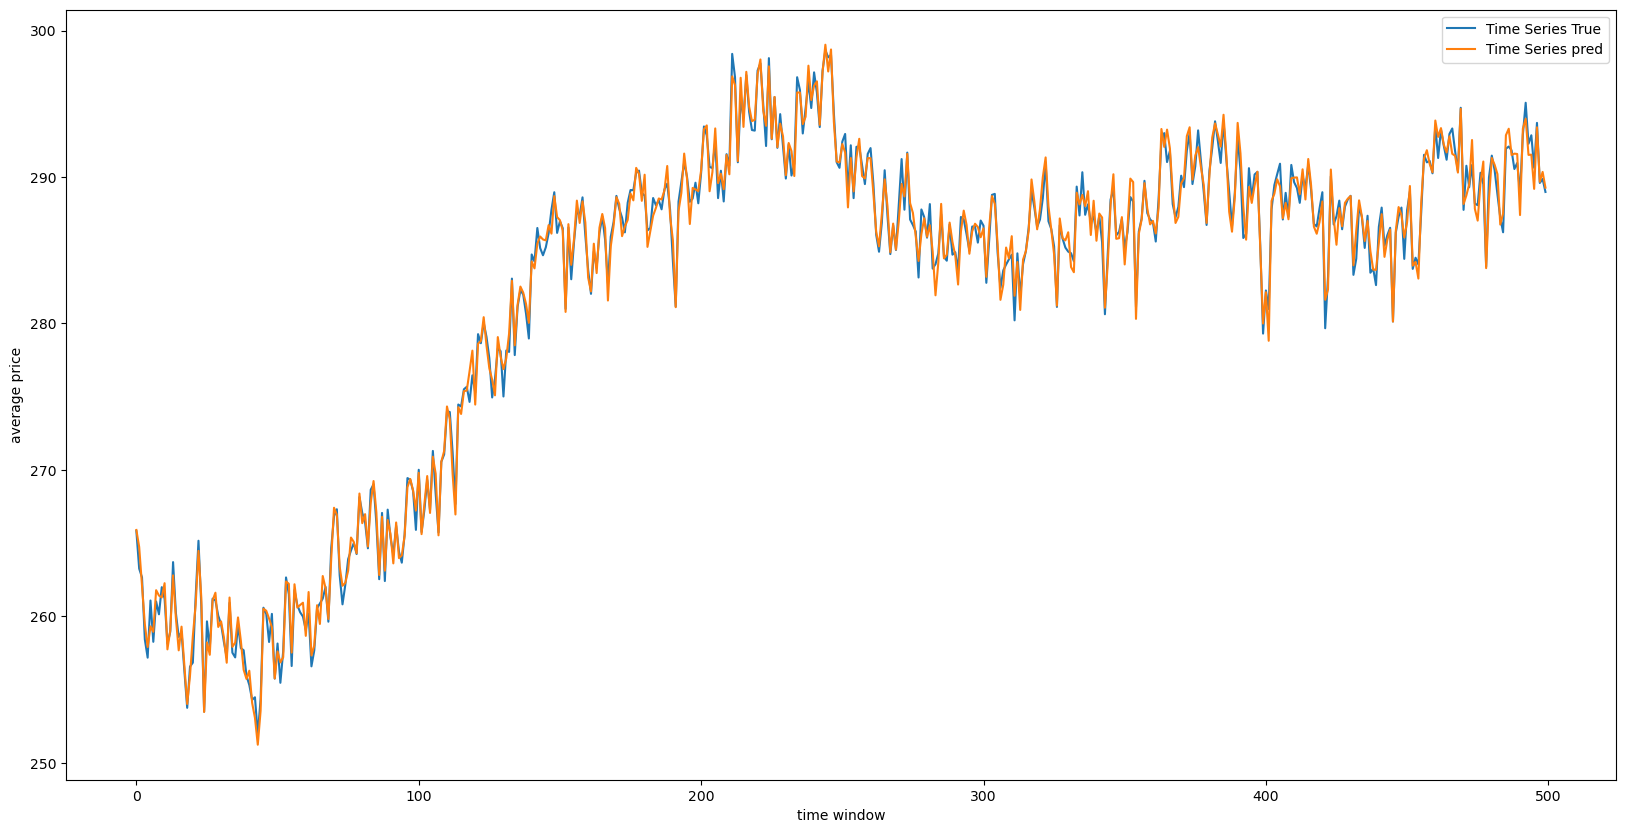

In [36]:
plt.figure(figsize=(20, 10))
plt.plot(mean_true, label='Time Series True')
plt.plot(mean_pred, label='Time Series pred')
plt.xlabel('time window')
plt.ylabel('average price')
plt.legend()
plt.show()

In [ ]:
# end 

In [ ]:
data_copy_slice_diff = data_copy.diff().dropna()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(data_copy_slice_diff, label='Time Series')
plt.xlabel('second')
plt.ylabel('price')
plt.legend()
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
plot_acf(data_copy_slice_diff['Weighted_Price'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

In [ ]:
plot_pacf(data_copy_slice_diff['Weighted_Price'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:
model = ARIMA(data_copy_slice['Weighted_Price'],order = (1,1,1))

In [ ]:
fitted_model = model.fit()

In [ ]:
fitted_model.summary()

In [ ]:
forecast = fitted_model.forecast(steps=10)

In [ ]:
forecast